In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import glob
import os.path
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [161]:
l = []
for file_name in glob.glob(os.path.join('./full/', '*.csv')):
    l.append(list(pd.read_csv(file_name).columns.values))
    
print("total number of artists: " + str(len(l)))
print("unique column names: " + str([list(x) for x in set(tuple(x) for x in l)]))

total number of artists: 1707
unique column names: [['Unnamed: 0', 'acousticness', 'album', 'album_uri', 'analysis_url', 'artist', 'available_markets', 'danceability', 'disc_number', 'duration_ms_x', 'duration_ms_y', 'energy', 'explicit', 'href', 'id', 'instrumentalness', 'is_local', 'key', 'liveness', 'loudness', 'mode', 'name', 'popularity', 'preview_url', 'release_date', 'speechiness', 'tempo', 'time_signature', 'track_number', 'uri', 'valence']]


In [4]:
audio = pd.concat([pd.read_csv(file_name) for file_name in glob.glob(os.path.join('./full/', '*.csv'))])
print(audio.shape)
audio.head()

(438598, 31)


,Unnamed: 0,acousticness,album,album_uri,analysis_url,artist,available_markets,danceability,disc_number,duration_ms_x,...,name,popularity,preview_url,release_date,speechiness,tempo,time_signature,track_number,uri,valence
0,0,0.882,The Best of Rosie & the Originals,spotify:album:2QgaDim6K6BvyqvTi9eG19,https://api.spotify.com/v1/audio-analysis/3mca...,the originals,"['AD', 'AR', 'AT', 'AU', 'BE', 'BG', 'BO', 'BR...",0.378,1,218000,...,Angel Baby,7,https://p.scdn.co/mp3-preview/137280f27aec33da...,2018-01-02,0.0313,196.826,3,1,spotify:track:3mca6Z0QFARtnY1sMm8dhn,0.542
1,1,0.819,The Best of Rosie & the Originals,spotify:album:2QgaDim6K6BvyqvTi9eG19,https://api.spotify.com/v1/audio-analysis/7fL0...,the originals,"['AD', 'AR', 'AT', 'AU', 'BE', 'BG', 'BO', 'BR...",0.604,1,192000,...,My Darling Forever,5,https://p.scdn.co/mp3-preview/6e6b96cb90b2085d...,2018-01-02,0.0255,94.511,3,2,spotify:track:7fL0kLsuvTK1EBx4A3Metx,0.310
2,2,0.931,The Best of Rosie & the Originals,spotify:album:2QgaDim6K6BvyqvTi9eG19,https://api.spotify.com/v1/audio-analysis/4cBU...,the originals,"['AD', 'AR', 'AT', 'AU', 'BE', 'BG', 'BO', 'BR...",0.319,1,184000,...,No Other Love Will Ever Do,4,https://p.scdn.co/mp3-preview/f02d0d3d60b2b51d...,2018-01-02,0.0490,186.645,3,3,spotify:track:4cBUo4ECEy0mIakYUYCGob,0.335
3,3,0.786,The Best of Rosie & the Originals,spotify:album:2QgaDim6K6BvyqvTi9eG19,https://api.spotify.com/v1/audio-analysis/6BTS...,the originals,"['AD', 'AR', 'AT', 'AU', 'BE', 'BG', 'BO', 'BR...",0.604,1,178000,...,Lonely Blue Nights,4,https://p.scdn.co/mp3-preview/ccd4f52cec106354...,2018-01-02,0.0322,102.220,3,4,spotify:track:6BTSG03D4E29J12GwPr0xQ,0.292
4,4,0.557,The Best of Rosie & the Originals,spotify:album:2QgaDim6K6BvyqvTi9eG19,https://api.spotify.com/v1/audio-analysis/71Hm...,the originals,"['AD', 'AR', 'AT', 'AU', 'BE', 'BG', 'BO', 'BR...",0.486,1,170000,...,Read the Story of Love,3,https://p.scdn.co/mp3-preview/686a13d7b9e81445...,2018-01-02,0.0560,113.783,4,5,spotify:track:71HmIXFxJ6CxlNy0plfqOG,0.533


In [5]:
# only keep albums in US avaiable in us market
audio = audio[audio.available_markets.str.contains("US")]

In [6]:
# remove rows with song names contains '-'
audio = audio[-audio.name.str.contains("-")]

In [7]:
# remove rows with album names contains 'edition'
audio = audio[-audio.album.str.contains("edition", case=False, na=False)]

In [8]:
# remove rows with same song and album, keep one with highest popularity
audio = audio.sort_values(by=['popularity']).drop_duplicates(subset=['album', 'name'], keep='last')

In [9]:
# remove rows with album names contains 'version'
audio = audio[-audio.album.str.contains("version", case=False, na=False)]

In [10]:
# drop unnecessary columns
audio.drop(['Unnamed: 0', 'album_uri', 'analysis_url', 'available_markets', 'disc_number', 'href', 'id',
            'is_local', 'preview_url', 'track_number', 'uri', 'duration_ms_y'], axis=1, inplace=True)
audio.head()

,acousticness,album,artist,danceability,duration_ms_x,energy,explicit,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,time_signature,valence
565,0.327,Christmas is ON!,gary us bonds,0.592,263533,0.585,False,0.000000,5,0.114,-10.578,0,Christmas Is a Phone Call Away,0,2012-09-11,0.1550,64.128,3,0.931
120,0.374,Don't Throw Your Love Away - 15 Top Tunes,the fortunes,0.712,204226,0.642,False,0.000134,9,0.174,-7.975,1,Lindsey,0,2009-12-21,0.0246,103.408,4,0.856
121,0.535,Don't Throw Your Love Away - 15 Top Tunes,the fortunes,0.610,211826,0.643,False,0.003080,2,0.274,-9.726,1,When I'm Gone,0,2009-12-21,0.0368,122.383,4,0.722
123,0.153,Don't Throw Your Love Away - 15 Top Tunes,the fortunes,0.786,252133,0.626,False,0.000203,11,0.181,-10.248,1,When Your Heart Speaks,0,2009-12-21,0.0302,115.243,4,0.962
58,0.464,No Doubt About It,terri gibbs,0.516,287034,0.388,False,0.000000,5,0.092,-8.850,1,Shout to the Lord,0,2002-01-01,0.0257,76.205,4,0.275


In [11]:
# create extra column for decades from release date
audio['release_date'] = pd.to_datetime(audio['release_date'], infer_datetime_format=True)

audio['year'] = audio['release_date'].dt.year
audio['month'] = audio['release_date'].dt.month
audio.drop(['release_date'], axis=1, inplace=True)
audio.head()

,acousticness,album,artist,danceability,duration_ms_x,energy,explicit,instrumentalness,key,liveness,loudness,mode,name,popularity,speechiness,tempo,time_signature,valence,year,month
565,0.327,Christmas is ON!,gary us bonds,0.592,263533,0.585,False,0.000000,5,0.114,-10.578,0,Christmas Is a Phone Call Away,0,0.1550,64.128,3,0.931,2012,9
120,0.374,Don't Throw Your Love Away - 15 Top Tunes,the fortunes,0.712,204226,0.642,False,0.000134,9,0.174,-7.975,1,Lindsey,0,0.0246,103.408,4,0.856,2009,12
121,0.535,Don't Throw Your Love Away - 15 Top Tunes,the fortunes,0.610,211826,0.643,False,0.003080,2,0.274,-9.726,1,When I'm Gone,0,0.0368,122.383,4,0.722,2009,12
123,0.153,Don't Throw Your Love Away - 15 Top Tunes,the fortunes,0.786,252133,0.626,False,0.000203,11,0.181,-10.248,1,When Your Heart Speaks,0,0.0302,115.243,4,0.962,2009,12
58,0.464,No Doubt About It,terri gibbs,0.516,287034,0.388,False,0.000000,5,0.092,-8.850,1,Shout to the Lord,0,0.0257,76.205,4,0.275,2002,1


(97604, 20)

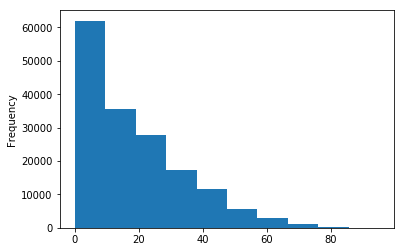

In [12]:
# observe distribution of popularity
audio.popularity.plot.hist()

# remove unpopular songs with popularity score <= 10
audio = audio[audio.popularity > 10]
audio.shape

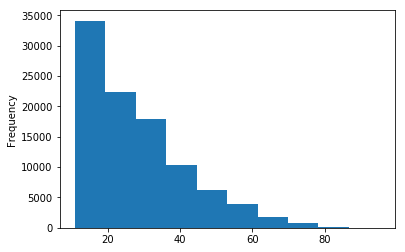

In [13]:
# observe distribution of popularity after removal
audio.popularity.plot.hist()

In [14]:
audio.duration_ms_x = audio.duration_ms_x/1000 # from ms to seconds
audio = audio[audio['year'] <= 2018][audio['year'] >= 1960] # remove those tracks from future and before 1960
# create decades column
audio['decade'] = np.where(audio.year <= 1969, "60s",
                           np.where(audio.year <= 1979, "70s", 
                                   np.where(audio.year <= 1989, "80s",
                                           np.where(audio.year <= 1999, "90s",
                                                   np.where(audio.year <= 2009, "00s", "10s")))))
# set data type correctly
for i in ['album','name', 'artist', 'key', 'mode', 'year', 'month', 'decade', 'time_signature']:
    audio[i] = audio[i].astype(np.object)
    
audio['explicit'] = audio['explicit'].astype(np.bool_)

audio.head()

,acousticness,album,artist,danceability,duration_ms_x,energy,explicit,instrumentalness,key,liveness,...,mode,name,popularity,speechiness,tempo,time_signature,valence,year,month,decade
840,0.979,Son Of Schmilsson,harry nilsson,0.502,294.066,0.0925,False,0.138000,0,0.0736,...,1,Campo de Encino,11,0.0305,65.079,4,0.130,1972,1,70s
276,0.592,Hits Collection: Tommy Roe,tommy roe,0.807,131.933,0.4150,False,0.144000,0,0.0884,...,1,"Yummy, Yummy, Yummy",11,0.0329,126.755,4,0.949,2012,11,10s
114,0.826,Mama's Big Ones',mama cass elliot,0.415,144.160,0.1800,False,0.006410,0,0.1570,...,1,Ain't Nobody Else Like You,11,0.0283,96.020,3,0.318,1973,1,70s
229,0.238,Straight From The Heart,peabo bryson,0.839,279.013,0.8820,False,0.000072,8,0.2360,...,0,Straight From The Heart,11,0.0460,125.272,4,0.933,1984,1,80s
66,0.902,"Country, My Way",nancy sinatra,0.514,196.866,0.4730,False,0.000168,9,0.2240,...,1,"Hello L.A., Bye Bye Birmingham",11,0.0424,152.847,4,0.656,2006,4,00s


In [15]:
audio.popularity.groupby([audio['decade'], audio['artist']]).mean()['10s'].nlargest(50)
# audio[audio.artist=='panic at the disco']

artist
bruno mars               73.178571
panic at the disco       68.612903
vance joy                68.461538
ed sheeran               67.520000
adele                    67.045455
sam hunt                 66.900000
melanie                  66.500000
the weeknd               65.857143
smith                    65.750000
ocean                    65.529412
coldplay                 65.352941
drake                    65.086614
hozier                   65.000000
sam smith                64.833333
kanye west               64.558140
fall out boy             62.968750
kendrick lamar           62.417582
j cole                   62.403226
lorde                    62.222222
red hot chili peppers    62.071429
ariana grande            61.761905
calvin harris            61.648649
flo rida                 61.437500
one direction            61.306122
john mayer               60.969697
the neighbourhood        60.560000
meghan trainor           60.357143
foster the people        60.071429
taylor swift 

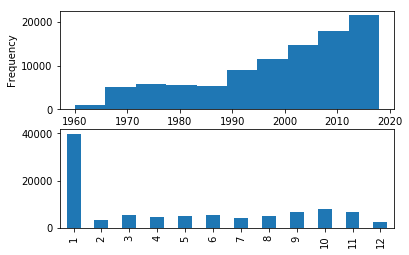

In [21]:
plt.subplot(2,1,1)
audio.year.plot.hist()
plt.subplot(2,1,2)
audio.month.value_counts().reindex_axis([1,2,3,4,5,6,7,8,9,10,11,12]).plot.bar()

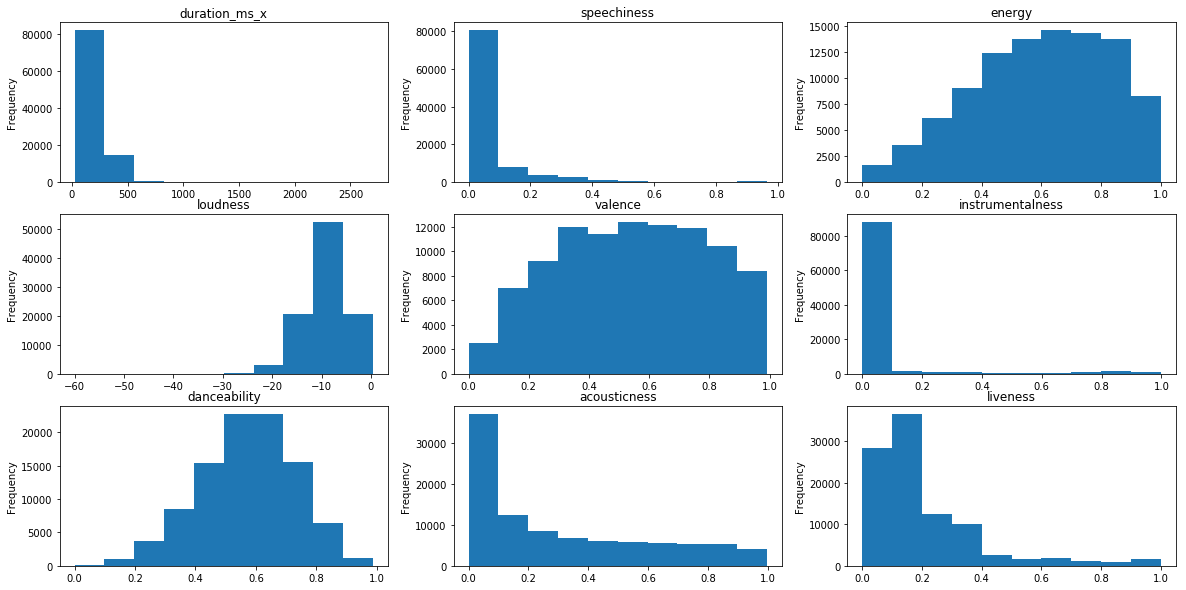

In [24]:
plt.rcParams['figure.figsize'] = [20, 10]

for idx, label in enumerate(['duration_ms_x', 'speechiness', 'energy',
                             'loudness', 'valence', 'instrumentalness',
                             'danceability', 'acousticness', 'liveness']):
    plt.subplot(3,3, idx+1)
    audio[label].plot.hist(ax=plt.gca(), title = label)

In [215]:
# descriptive analysis

# average attributes by decades
aver_audio = audio.drop(['explicit', 'month', 'key', 'mode', 'time_signature', 'year'], axis=1).groupby("decade", as_index=True).mean()
aver_audio = aver_audio.reindex_axis(['60s', '70s', '80s', '90s', '00s', '10s'], axis=0)

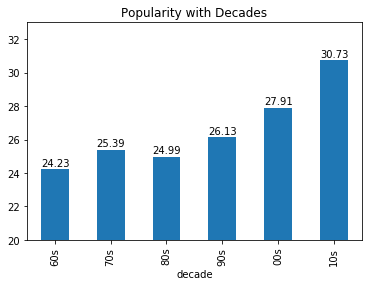

In [216]:
popularity_plt = aver_audio.popularity.plot.bar(title='Popularity with Decades', ylim=(20,33))

for idx, label in enumerate(list(aver_audio.index)): 
        value = np.round(aver_audio.iloc[idx]['popularity'],decimals=2)
        popularity_plt.annotate(value,
                    (idx-0.25, value+0.2))

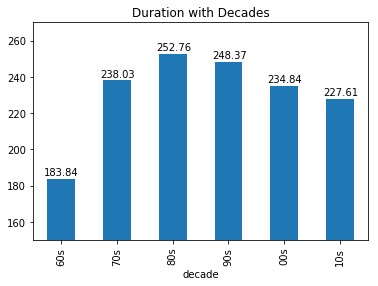

In [217]:
duration_plt = aver_audio.duration_ms_x.plot.bar(title='Duration with Decades', ylim = (150, 270))

for idx, label in enumerate(list(aver_audio.index)): 
        value = np.round(aver_audio.iloc[idx]['duration_ms_x'],decimals=2)
        duration_plt.annotate(value,
                    (idx-0.3, value+2))

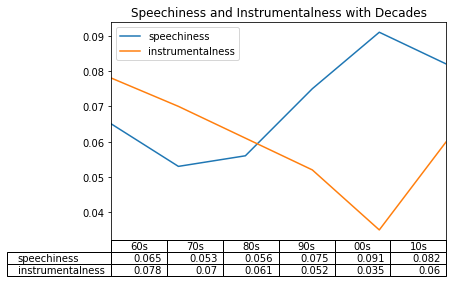

In [218]:
si_plt = np.round(aver_audio[["speechiness", "instrumentalness"]], decimals=3).plot(title="Speechiness and Instrumentalness with Decades", table=True, xticks=None)
si_plt.get_xaxis().set_visible(False)

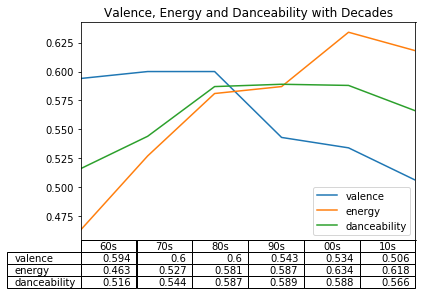

In [219]:
ved_plt = np.round(aver_audio[["valence", "energy", "danceability"]], decimals=3).plot(title="Valence, Energy and Danceability with Decades", table=True)
ved_plt.get_xaxis().set_visible(False)

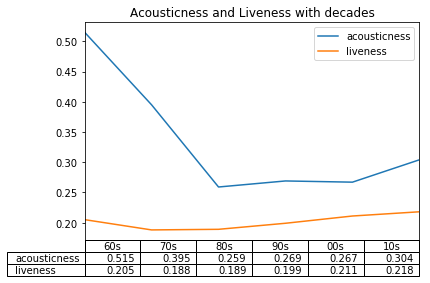

In [220]:
al_plt = np.round(aver_audio[['acousticness', 'liveness']], decimals=3).plot(title="Acousticness and Liveness with decades", table=True)
al_plt.get_xaxis().set_visible(False)

In [221]:
# best and worst artist in different decades
aver_artist = audio.popularity.groupby([audio['decade'], audio['artist']]).mean()
for i in ["60s", '70s', '80s', '90s', '00s', '10s']:
    artists = aver_artist[i]
    print("%s 5 most popular artists:"%i)
    print(", ".join(artists.nlargest(5).index.values))
    print("%s 5 least popular artists:"%i)
    print(", ".join(artists.nsmallest(5).index.values))
    print("="*10)

60s 5 most popular artists:
the doors, anne murray, simon  garfunkel, mason williams, roberta flack
60s 5 least popular artists:
chuck mangione, climax blues band, genesis, lou christie, ahmad
70s 5 most popular artists:
bob seger, crosby stills  nash, simon  garfunkel, pink floyd, boston
70s 5 least popular artists:
frijid pink, new colony six, rita coolidge, shirley bassey, smokey robinson
80s 5 most popular artists:
guns n roses, whitney houston, silver, tracy chapman, michael jackson
80s 5 least popular artists:
jonathan edwards, maureen mcgovern, shaun cassidy, smokey robinson, the knack
90s 5 most popular artists:
pink floyd, dr dre, matchbox 20, the notorious big, hot
90s 5 least popular artists:
christie, frank stallone, idina menzel, jay and the americans, joe simon
00s 5 most popular artists:
coldplay, drake, john mayer, mumford  sons, panic at the disco
00s 5 least popular artists:
8th day, belinda carlisle, deep blue something, melissa manchester, meredith brooks
10s 5 most

In [222]:
# best and worst tracks in different decades
for i in ["60s", '70s', '80s', '90s', '00s', '10s']:
    print("%s 5 most popular tracks:"%i)
    print(", ".join(list(audio[audio['decade']==i][['popularity', 'name']].sort_values('popularity', ascending=False)[:5]['name'])))
    print("%s 5 least popular tracks:"%i)
    print(", ".join(list(audio[audio['decade']==i][['popularity', 'name']].sort_values('popularity')[:5]['name'])))
    print("="*10)

60s 5 most popular tracks:
Stand By Me, For What It's Worth, Mrs. Robinson, Happy Together, Stand By Me
60s 5 least popular tracks:
(Just Enough to Keep Me) Hangin' On, Laugh Laugh, Over The Rainbow, Backbiting Baby, You've Made Me So Very Happy
70s 5 most popular tracks:
Mr. Blue Sky, Dream On, More Than a Feeling, Ain't No Sunshine, Carry on Wayward Son
70s 5 least popular tracks:
Campo de Encino, Animal Instincts, Number One, Twisted, Introduction
80s 5 most popular tracks:
Take On Me, Africa, I Wanna Dance with Somebody (Who Loves Me), Fast Car, Walking On Sunshine
80s 5 least popular tracks:
Straight From The Heart, Emerald City, Double It Up, When We Made Love, (The Word Of) Confirmation
90s 5 most popular tracks:
Gangsta's Paradise, No Scrubs, Juicy, Basket Case, Ambitionz Az A Ridah
90s 5 least popular tracks:
Don't Be A Baby, Baby, Harder Than Your Husband, You're The Only Reason, Watch The Woman's Hands, Pay No Attention To Alice
00s 5 most popular tracks:
The Scientist, I'm 

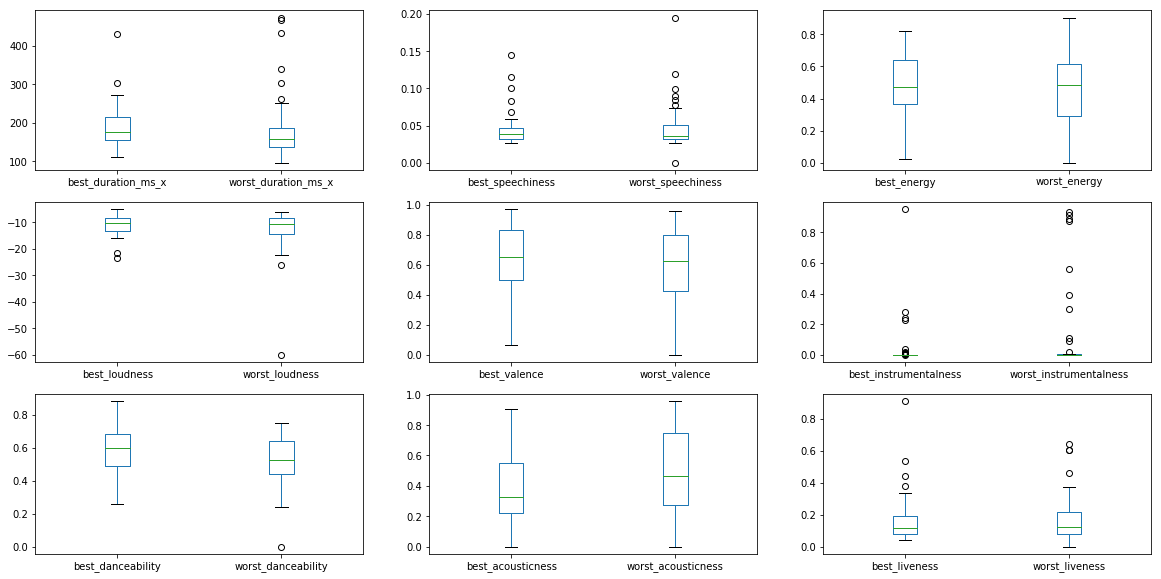

In [224]:
# comparison between the top 50 most and least popular tracks in each decades?

# 60s
bests = audio[audio['decade']=='60s'].sort_values('popularity', ascending=False)[:50]
worsts = audio[audio['decade']=='60s'].sort_values('popularity', ascending=True)[:50]

plt.rcParams['figure.figsize'] = [20, 10]

for idx, label in enumerate(['duration_ms_x', 'speechiness', 'energy',
                             'loudness', 'valence', 'instrumentalness',
                             'danceability', 'acousticness', 'liveness']):
    plt.subplot(3,3, idx+1)
    temp = pd.concat([bests[label].reset_index(drop=True), worsts[label].reset_index(drop=True)], axis=1)
    temp.columns = ['best_%s'%label, 'worst_%s'%label]
    temp.plot.box(ax=plt.gca())

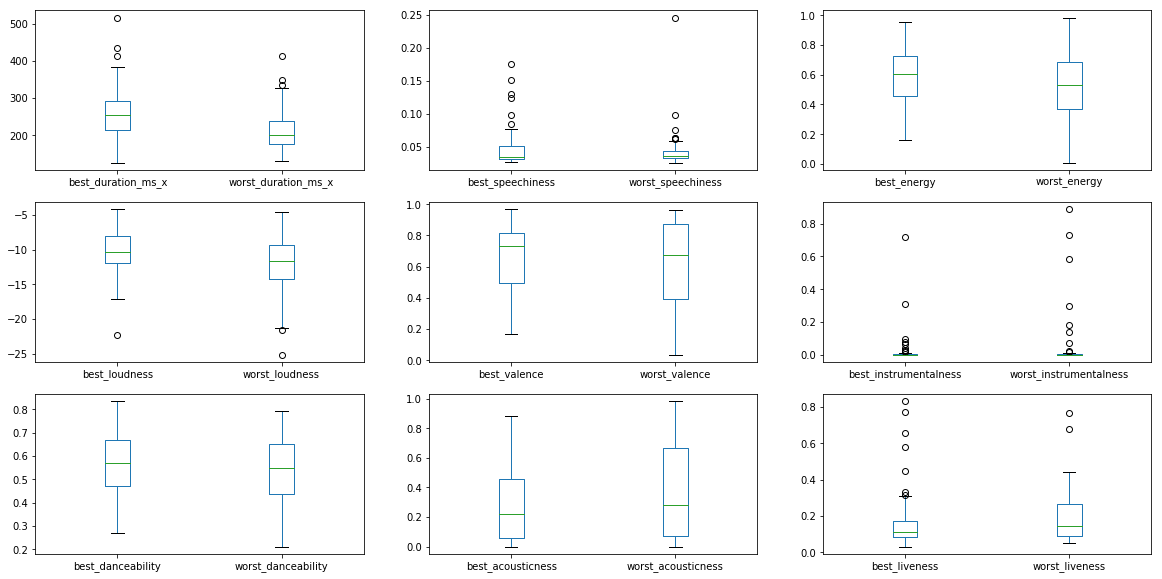

In [225]:
# 70s
bests = audio[audio['decade']=='70s'].sort_values('popularity', ascending=False)[:50]
worsts = audio[audio['decade']=='70s'].sort_values('popularity', ascending=True)[:50]

plt.rcParams['figure.figsize'] = [20, 10]

for idx, label in enumerate(['duration_ms_x', 'speechiness', 'energy',
                             'loudness', 'valence', 'instrumentalness',
                             'danceability', 'acousticness', 'liveness']):
    plt.subplot(3,3, idx+1)
    temp = pd.concat([bests[label].reset_index(drop=True), worsts[label].reset_index(drop=True)], axis=1)
    temp.columns = ['best_%s'%label, 'worst_%s'%label]
    temp.plot.box(ax=plt.gca())

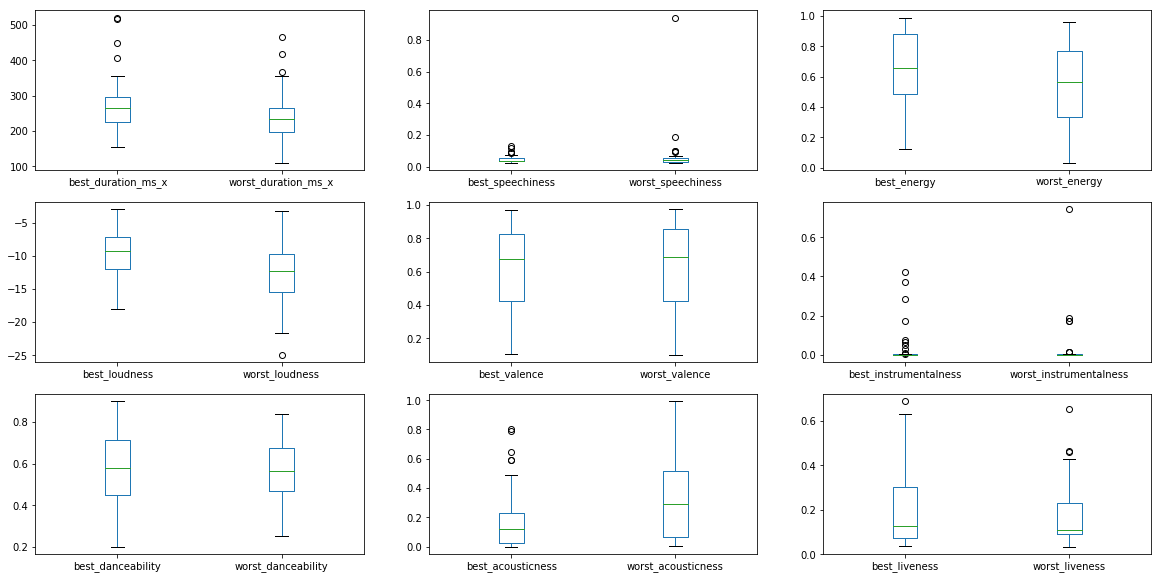

In [226]:
# 80s
bests = audio[audio['decade']=='80s'].sort_values('popularity', ascending=False)[:50]
worsts = audio[audio['decade']=='80s'].sort_values('popularity', ascending=True)[:50]

plt.rcParams['figure.figsize'] = [20, 10]

for idx, label in enumerate(['duration_ms_x', 'speechiness', 'energy',
                             'loudness', 'valence', 'instrumentalness',
                             'danceability', 'acousticness', 'liveness']):
    plt.subplot(3,3, idx+1)
    temp = pd.concat([bests[label].reset_index(drop=True), worsts[label].reset_index(drop=True)], axis=1)
    temp.columns = ['best_%s'%label, 'worst_%s'%label]
    temp.plot.box(ax=plt.gca())

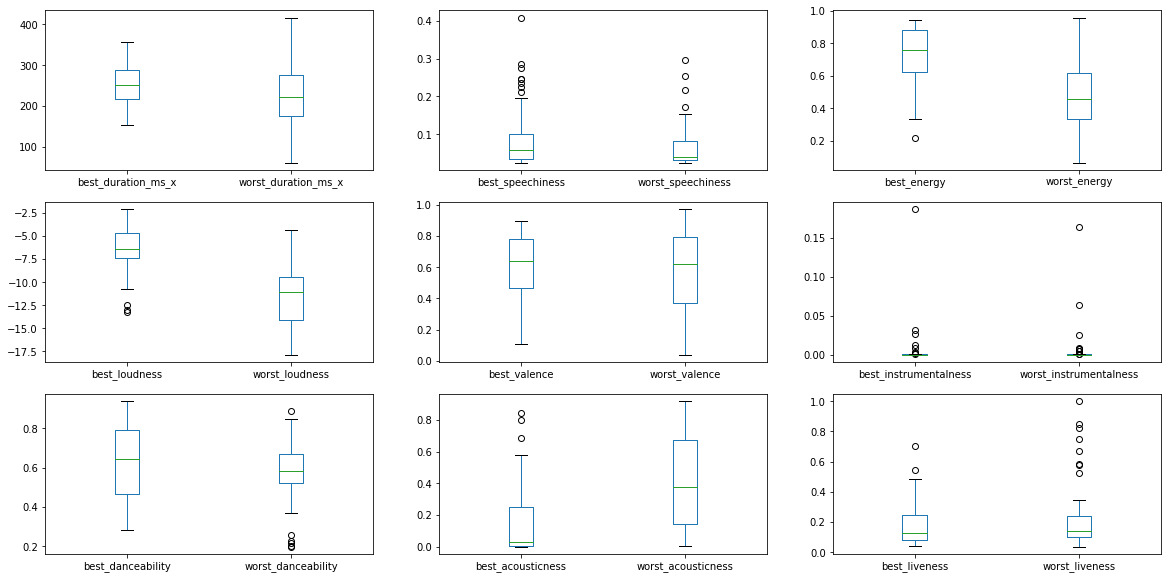

In [228]:
# 90s
bests = audio[audio['decade']=='90s'].sort_values('popularity', ascending=False)[:50]
worsts = audio[audio['decade']=='90s'].sort_values('popularity', ascending=True)[:50]

plt.rcParams['figure.figsize'] = [20, 10]

for idx, label in enumerate(['duration_ms_x', 'speechiness', 'energy',
                             'loudness', 'valence', 'instrumentalness',
                             'danceability', 'acousticness', 'liveness']):
    plt.subplot(3,3, idx+1)
    temp = pd.concat([bests[label].reset_index(drop=True), worsts[label].reset_index(drop=True)], axis=1)
    temp.columns = ['best_%s'%label, 'worst_%s'%label]
    temp.plot.box(ax=plt.gca())

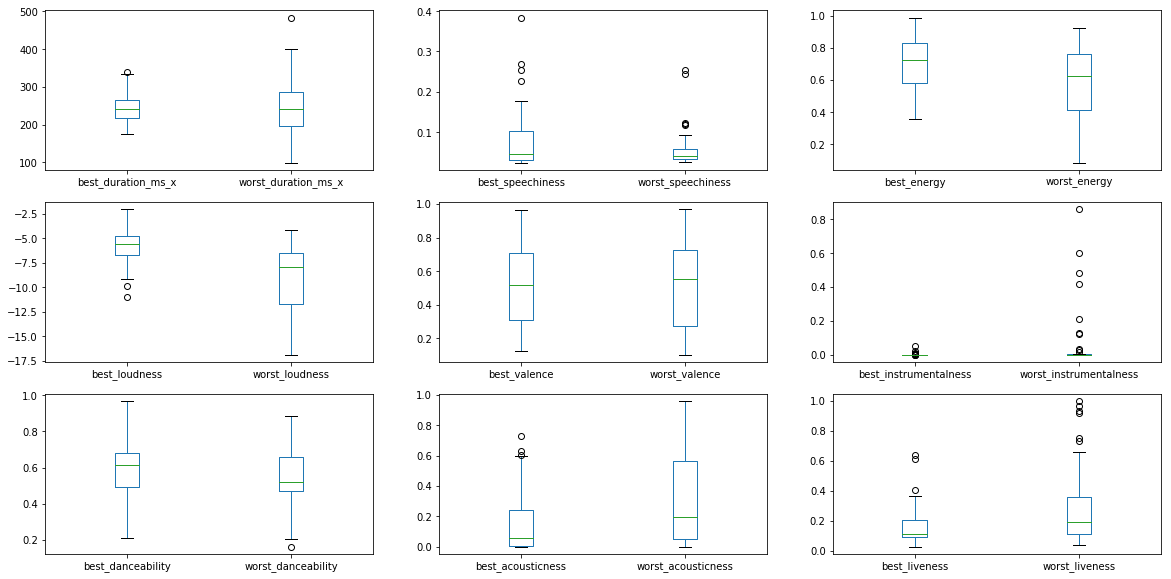

In [229]:
# 00s
bests = audio[audio['decade']=='00s'].sort_values('popularity', ascending=False)[:50]
worsts = audio[audio['decade']=='00s'].sort_values('popularity', ascending=True)[:50]

plt.rcParams['figure.figsize'] = [20, 10]

for idx, label in enumerate(['duration_ms_x', 'speechiness', 'energy',
                             'loudness', 'valence', 'instrumentalness',
                             'danceability', 'acousticness', 'liveness']):
    plt.subplot(3,3, idx+1)
    temp = pd.concat([bests[label].reset_index(drop=True), worsts[label].reset_index(drop=True)], axis=1)
    temp.columns = ['best_%s'%label, 'worst_%s'%label]
    temp.plot.box(ax=plt.gca())

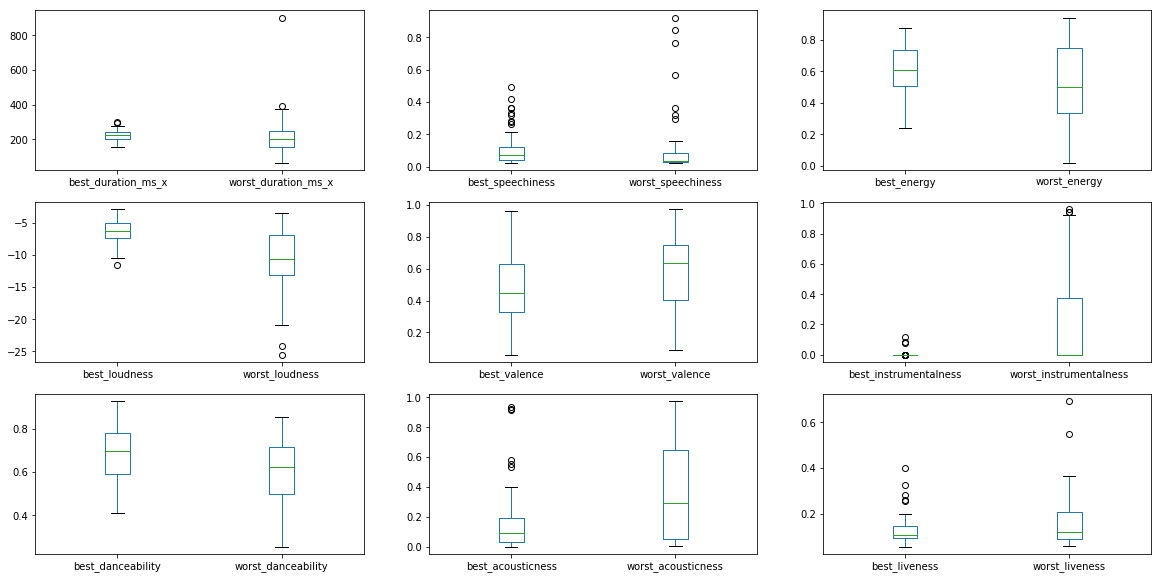

In [230]:
# 10s
bests = audio[audio['decade']=='10s'].sort_values('popularity', ascending=False)[:50]
worsts = audio[audio['decade']=='10s'].sort_values('popularity', ascending=True)[:50]

plt.rcParams['figure.figsize'] = [20, 10]

for idx, label in enumerate(['duration_ms_x', 'speechiness', 'energy',
                             'loudness', 'valence', 'instrumentalness',
                             'danceability', 'acousticness', 'liveness']):
    plt.subplot(3,3, idx+1)
    temp = pd.concat([bests[label].reset_index(drop=True), worsts[label].reset_index(drop=True)], axis=1)
    temp.columns = ['best_%s'%label, 'worst_%s'%label]
    temp.plot.box(ax=plt.gca())

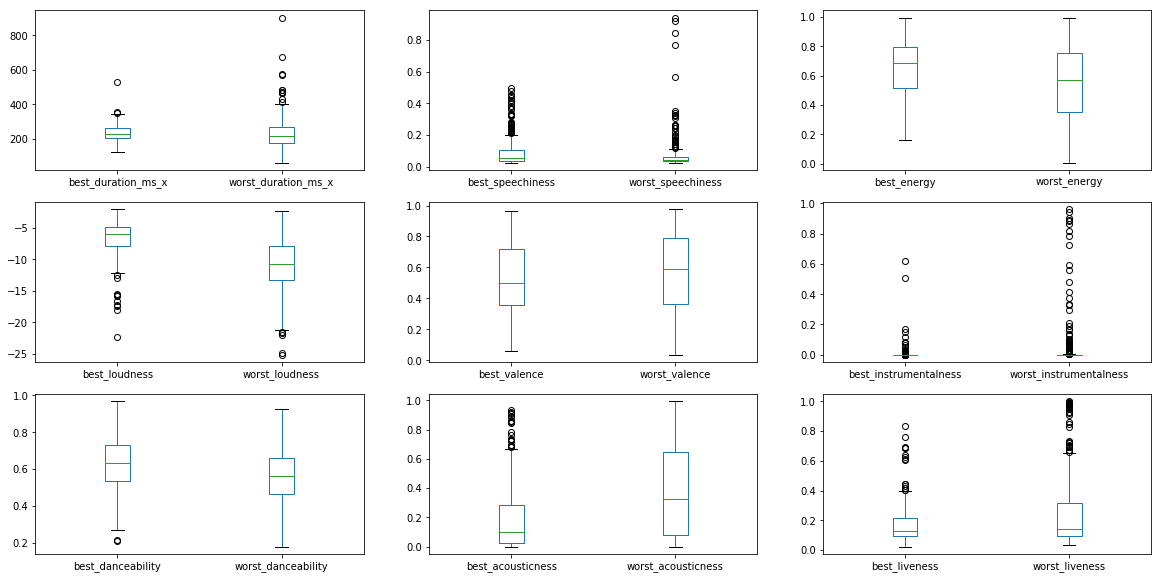

In [231]:
# overall, 300 best vs 300 worst
bests = audio.sort_values('popularity', ascending=False)[:300]
worsts = audio.sort_values('popularity', ascending=True)[:300]

plt.rcParams['figure.figsize'] = [20, 10]

for idx, label in enumerate(['duration_ms_x', 'speechiness', 'energy',
                             'loudness', 'valence', 'instrumentalness',
                             'danceability', 'acousticness', 'liveness']):
    plt.subplot(3,3, idx+1)
    temp = pd.concat([bests[label].reset_index(drop=True), worsts[label].reset_index(drop=True)], axis=1)
    temp.columns = ['best_%s'%label, 'worst_%s'%label]
    temp.plot.box(ax=plt.gca())

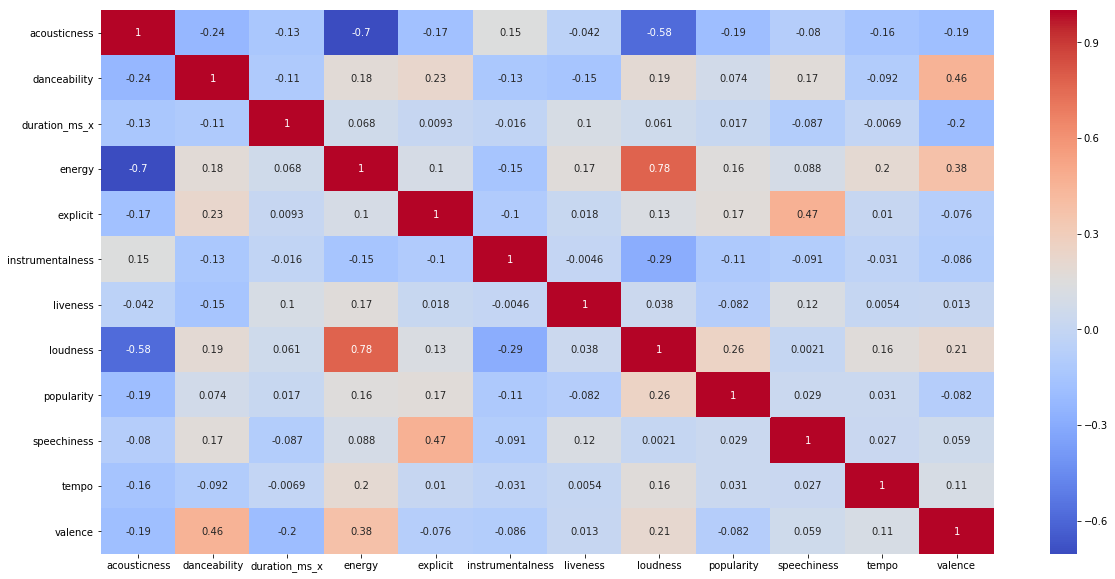

In [232]:
# 10s correlation
sns.heatmap(audio[audio['decade']=='10s'].corr(), cmap='coolwarm', annot=True)

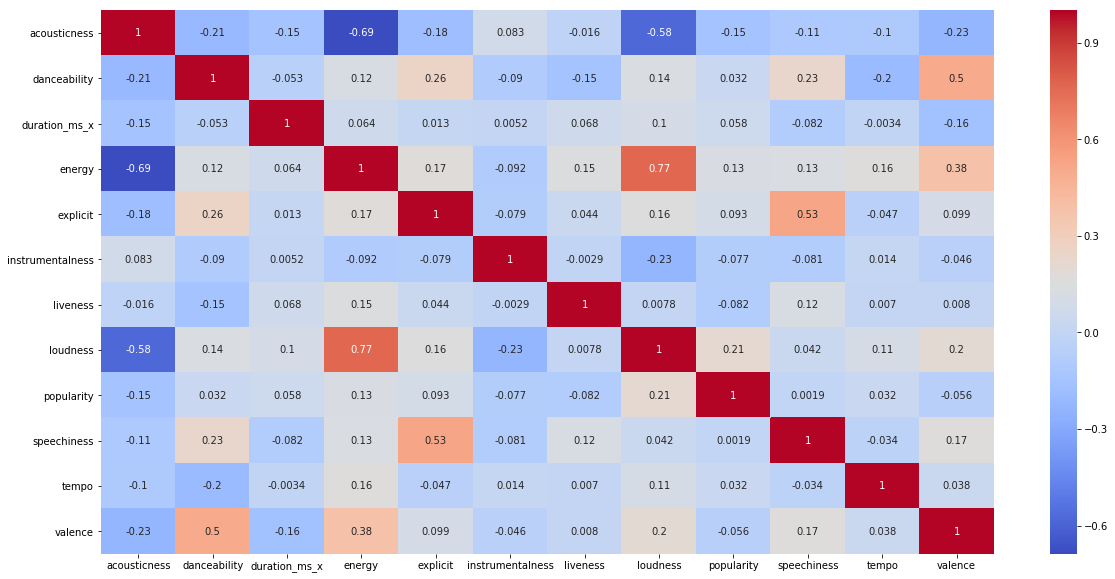

In [233]:
# 00s correlation
sns.heatmap(audio[audio['decade']=='00s'].corr(), cmap='coolwarm', annot=True)

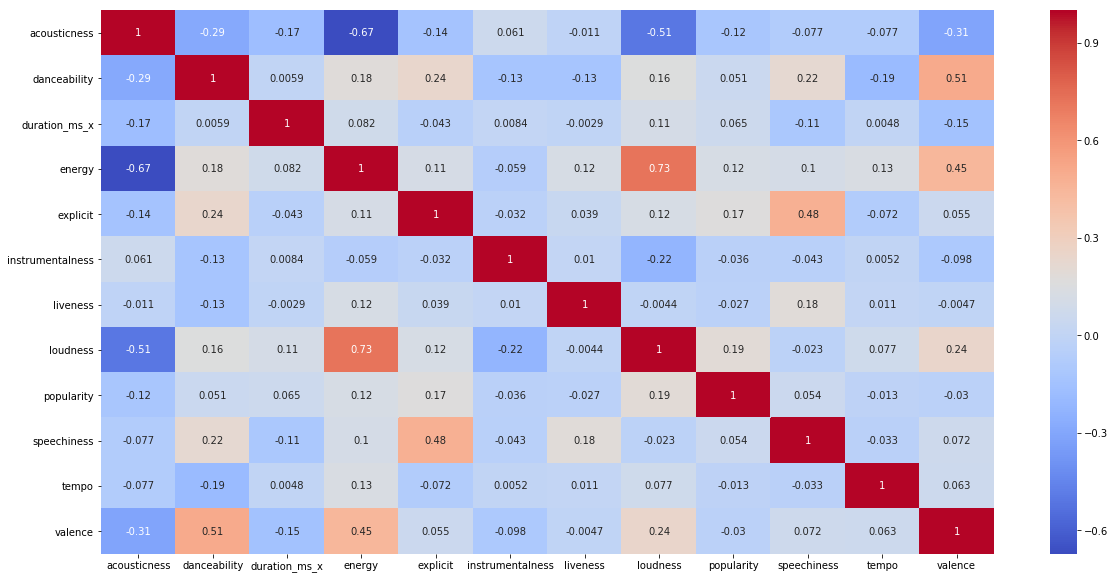

In [234]:
# 90s correlation
sns.heatmap(audio[audio['decade']=='90s'].corr(), cmap='coolwarm', annot=True)

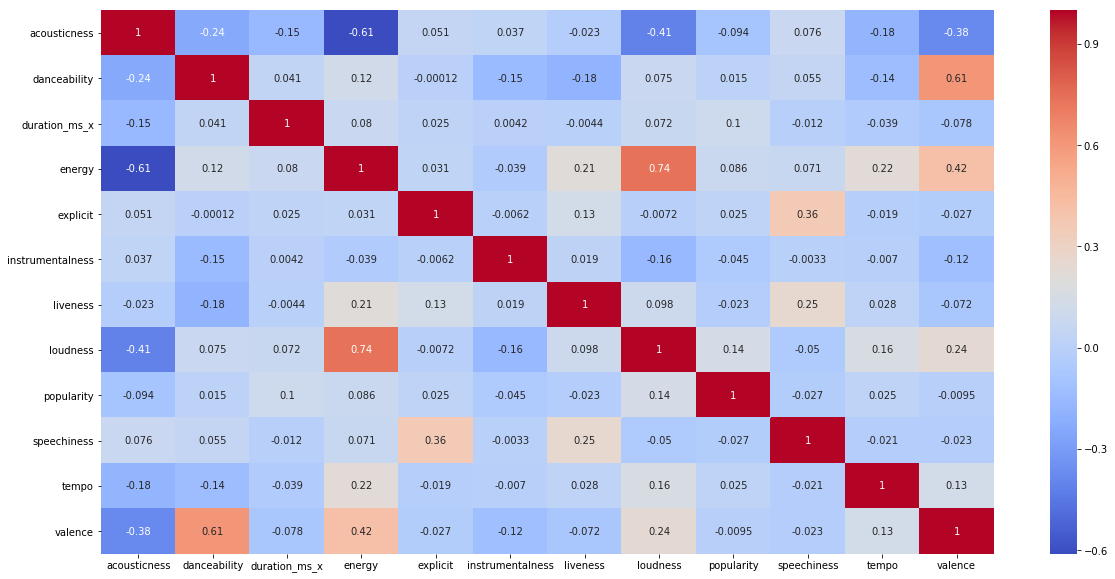

In [235]:
# 80s correlation
sns.heatmap(audio[audio['decade']=='80s'].corr(), cmap='coolwarm', annot=True)

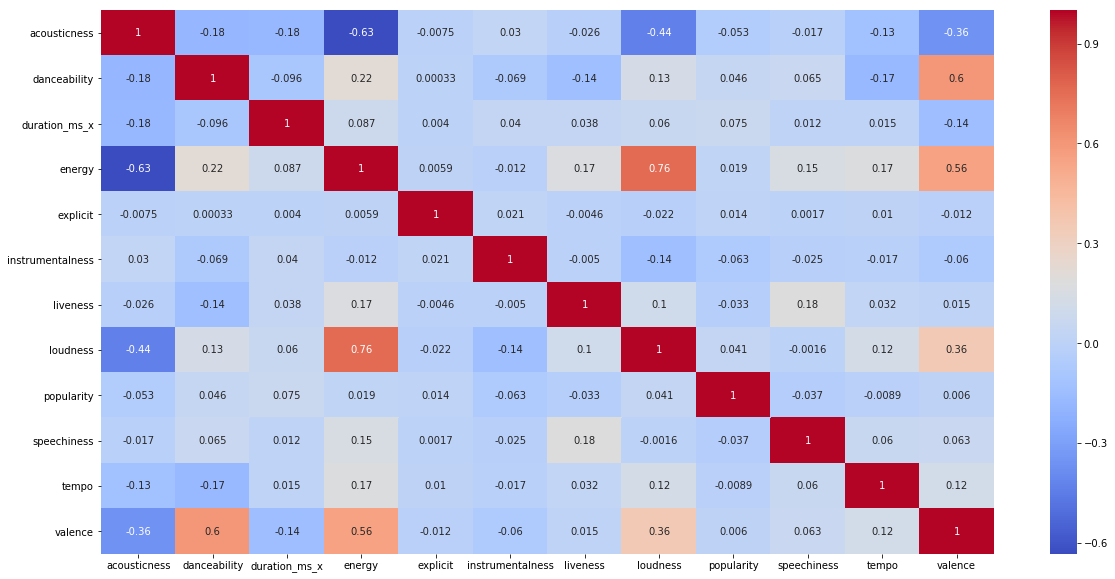

In [236]:
# 70s correlation
sns.heatmap(audio[audio['decade']=='70s'].corr(), cmap='coolwarm', annot=True)

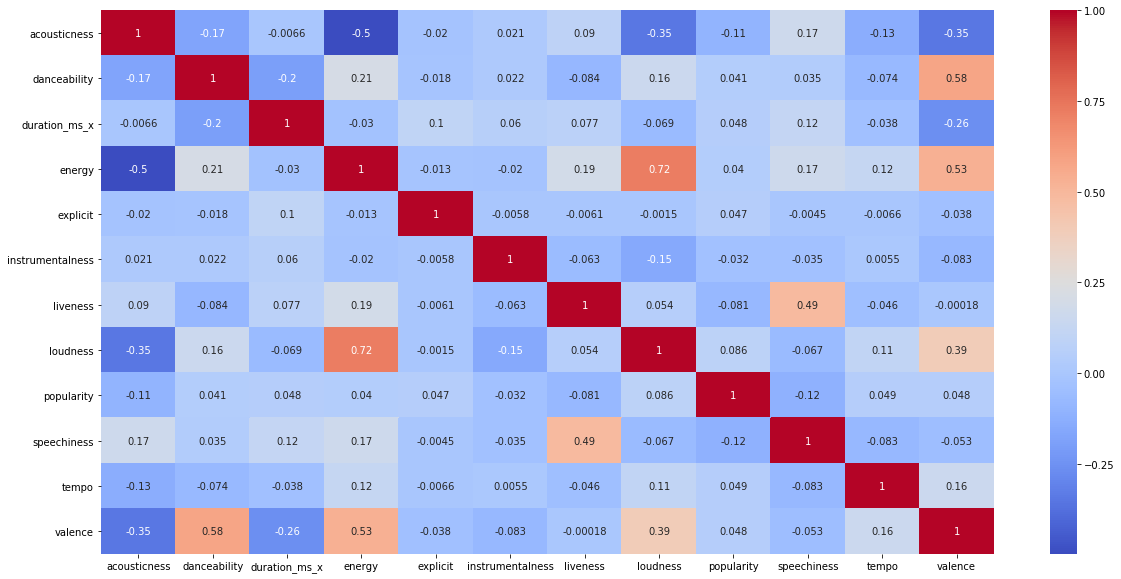

In [237]:
# 60s correlation
sns.heatmap(audio[audio['decade']=='60s'].corr(), cmap='coolwarm', annot=True)

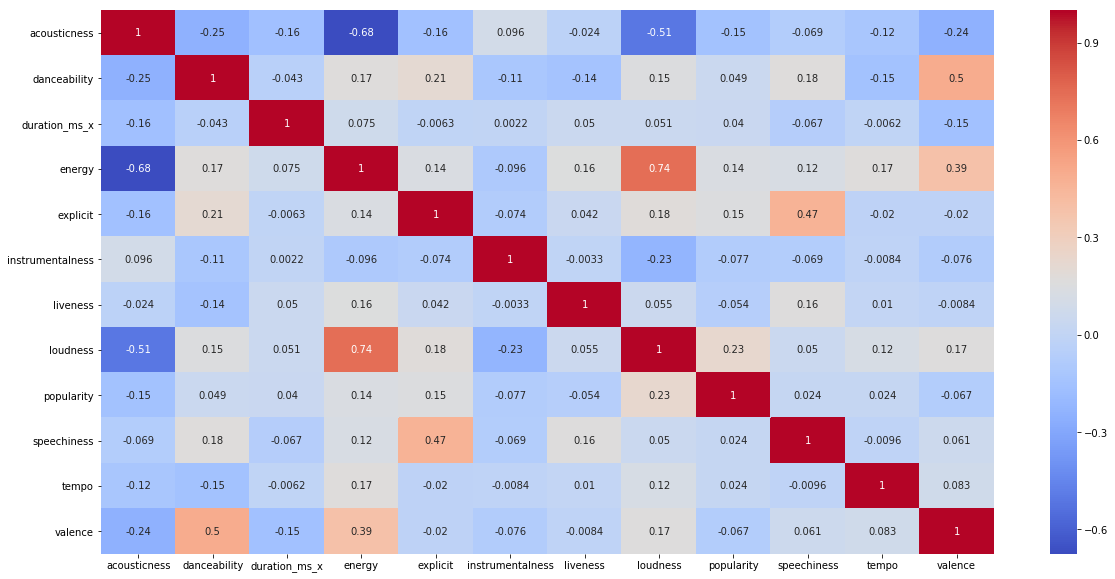

In [238]:
# overall correlation
sns.heatmap(audio.corr(), cmap='coolwarm', annot=True)

In [186]:
X = pd.get_dummies(audio.drop(['popularity', 'name', 'album', 'year', 'month', 'artist', 'explicit', 'decade'], axis=1))
X.valence.fillna(X.valence.mean(), inplace=True)
for i in ['acousticness', 'danceability', 'duration_ms_x', 'energy',
       'instrumentalness', 'liveness', 'loudness',
       'speechiness', 'tempo', 'valence']:
    X[i] = (X[i] - X[i].mean())/X[i].var()
y = np.log(audio.popularity)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4222)
X_train.head()

,acousticness,danceability,duration_ms_x,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,...,key_9,key_10,key_11,mode_0,mode_1,time_signature_0,time_signature_1,time_signature_3,time_signature_4,time_signature_5
115,0.998751,4.407522,-0.015169,6.343205,-1.696109,-4.789266,0.362589,8.353128,-0.007603,7.061230,...,0,0,0,0,1,0,1,0,0,0
29,3.202982,-6.281508,-0.007689,5.368259,-1.696109,4.130956,0.413376,9.245292,-0.059163,5.888013,...,0,0,0,0,1,0,0,1,0,0
28,-3.148804,-3.070735,-0.000777,-0.773900,-1.695626,1.170251,0.257904,-2.223961,-0.073840,0.038448,...,0,0,0,0,1,0,0,0,1,0
37,-2.406562,1.725104,-0.000883,2.618912,-1.696109,-0.442014,0.207004,-2.749346,0.004641,-3.679495,...,0,0,0,0,1,0,0,0,1,0
235,-2.562883,10.910354,-0.001865,3.476864,-1.696109,-4.314381,0.125281,-1.589534,-0.022710,1.790013,...,0,0,0,1,0,0,0,0,1,0


In [104]:
lasso_model = Lasso()
pipe = make_pipeline(lasso_model)
cross_val_score(pipe, X_train, y_train, cv = 10, scoring = 'neg_mean_squared_error').mean()

-0.23512573957235272

In [105]:
lasso_model.fit(X_train, y_train)
predict_y = lasso_model.predict(X_test)

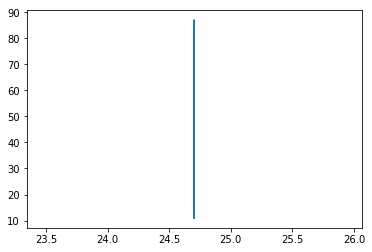

In [106]:
plt.plot(np.exp(predict_y), np.exp(y_test))

In [107]:
ridge_model = Ridge()
pipe = make_pipeline(ridge_model)
cross_val_score(pipe, X_train, y_train, cv = 10, scoring = 'neg_mean_squared_error').mean()

-0.21644434422543615

In [108]:
ridge_model.fit(X_train, y_train)
predict_y_ridge = ridge_model.predict(X_test)

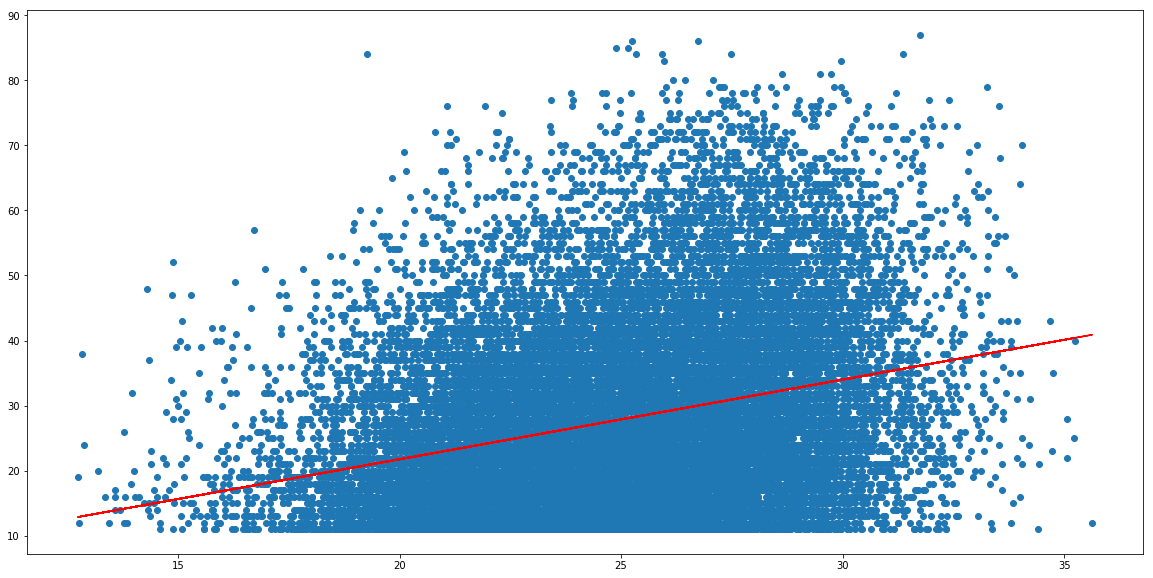

In [254]:
plt.scatter(np.exp(predict_y_ridge), np.exp(y_test))
slope, intercept = np.polyfit(np.exp(predict_y_ridge), np.exp(y_test), 1)
abline_values = [slope * i + intercept for i in np.exp(predict_y_ridge)]
plt.plot(np.exp(predict_y_ridge), abline_values, 'r')

In [135]:
pd.DataFrame({'lasso coef': lasso_model.coef_, 'ridge coef': ridge_model.coef_}, X_train.columns.values)

,lasso coef,ridge coef
acousticness,-0.0,-0.010175
danceability,0.0,0.004038
duration_ms_x,0.0,0.073210
energy,0.0,-0.004192
instrumentalness,-0.0,-0.002000
liveness,-0.0,-0.005331
loudness,0.0,1.598562
speechiness,0.0,0.000638
tempo,0.0,0.066204
valence,-0.0,-0.017427


In [148]:
# Grid Search
params = {
    'alpha': 10**np.linspace(5,-6,100)
}
lasso_gsc = GridSearchCV(lasso_model, params, cv=10, verbose = 5)
ridge_gsc = GridSearchCV(ridge_model, params, cv=10, verbose = 5)
lasso_gsc.fit(X_train, y_train)
ridge_gsc.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] alpha=100000.0 ..................................................
[CV] .... alpha=100000.0, score=-1.1495475318090698e-05, total=   0.1s
[CV] alpha=100000.0 ..................................................
[CV] ..... alpha=100000.0, score=-0.0005642353309782688, total=   0.1s
[CV] alpha=100000.0 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


[CV] ..... alpha=100000.0, score=-4.222782106211298e-07, total=   0.1s
[CV] alpha=100000.0 ..................................................
[CV] .... alpha=100000.0, score=-4.3114754514128606e-05, total=   0.1s
[CV] alpha=100000.0 ..................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s


[CV] .... alpha=100000.0, score=-2.0904934800780595e-05, total=   0.1s
[CV] alpha=100000.0 ..................................................
[CV] ..... alpha=100000.0, score=-4.643961458494772e-06, total=   0.1s
[CV] alpha=100000.0 ..................................................
[CV] ..... alpha=100000.0, score=-6.706410447221423e-05, total=   0.2s
[CV] alpha=100000.0 ..................................................
[CV] ..... alpha=100000.0, score=-0.0001748639305754196, total=   0.2s
[CV] alpha=100000.0 ..................................................
[CV] ..... alpha=100000.0, score=-5.235416094051537e-05, total=   0.2s
[CV] alpha=100000.0 ..................................................
[CV] .... alpha=100000.0, score=-1.3455544634055627e-06, total=   0.1s
[CV] alpha=77426.3682681 .............................................
[CV]  alpha=77426.3682681, score=-1.1495475318090698e-05, total=   0.1s
[CV] alpha=77426.3682681 .............................................
[CV] 

[CV]  alpha=21544.3469003, score=-4.3114754514128606e-05, total=   0.1s
[CV] alpha=21544.3469003 .............................................
[CV]  alpha=21544.3469003, score=-2.0904934800780595e-05, total=   0.2s
[CV] alpha=21544.3469003 .............................................
[CV]  alpha=21544.3469003, score=-4.643961458494772e-06, total=   0.2s
[CV] alpha=21544.3469003 .............................................
[CV]  alpha=21544.3469003, score=-6.706410447221423e-05, total=   0.1s
[CV] alpha=21544.3469003 .............................................
[CV]  alpha=21544.3469003, score=-0.0001748639305754196, total=   0.3s
[CV] alpha=21544.3469003 .............................................
[CV]  alpha=21544.3469003, score=-5.235416094051537e-05, total=   0.1s
[CV] alpha=21544.3469003 .............................................
[CV]  alpha=21544.3469003, score=-1.3455544634055627e-06, total=   0.1s
[CV] alpha=16681.005372 ..............................................
[CV

[CV]  alpha=4641.58883361, score=-4.222782106211298e-07, total=   0.1s
[CV] alpha=4641.58883361 .............................................
[CV]  alpha=4641.58883361, score=-4.3114754514128606e-05, total=   0.2s
[CV] alpha=4641.58883361 .............................................
[CV]  alpha=4641.58883361, score=-2.0904934800780595e-05, total=   0.1s
[CV] alpha=4641.58883361 .............................................
[CV]  alpha=4641.58883361, score=-4.643961458494772e-06, total=   0.1s
[CV] alpha=4641.58883361 .............................................
[CV]  alpha=4641.58883361, score=-6.706410447221423e-05, total=   0.1s
[CV] alpha=4641.58883361 .............................................
[CV]  alpha=4641.58883361, score=-0.0001748639305754196, total=   0.1s
[CV] alpha=4641.58883361 .............................................
[CV]  alpha=4641.58883361, score=-5.235416094051537e-05, total=   0.1s
[CV] alpha=4641.58883361 .............................................
[CV]

[CV] ...... alpha=1000.0, score=-1.1495475318090698e-05, total=   0.1s
[CV] alpha=1000.0 ....................................................
[CV] ....... alpha=1000.0, score=-0.0005642353309782688, total=   0.1s
[CV] alpha=1000.0 ....................................................
[CV] ....... alpha=1000.0, score=-4.222782106211298e-07, total=   0.1s
[CV] alpha=1000.0 ....................................................
[CV] ...... alpha=1000.0, score=-4.3114754514128606e-05, total=   0.1s
[CV] alpha=1000.0 ....................................................
[CV] ...... alpha=1000.0, score=-2.0904934800780595e-05, total=   0.1s
[CV] alpha=1000.0 ....................................................
[CV] ....... alpha=1000.0, score=-4.643961458494772e-06, total=   0.1s
[CV] alpha=1000.0 ....................................................
[CV] ....... alpha=1000.0, score=-6.706410447221423e-05, total=   0.1s
[CV] alpha=1000.0 ....................................................
[CV] .

[CV]  alpha=278.255940221, score=-5.235416094051537e-05, total=   0.3s
[CV] alpha=278.255940221 .............................................
[CV]  alpha=278.255940221, score=-1.3455544634055627e-06, total=   0.1s
[CV] alpha=215.443469003 .............................................
[CV]  alpha=215.443469003, score=-1.1495475318090698e-05, total=   0.1s
[CV] alpha=215.443469003 .............................................
[CV]  alpha=215.443469003, score=-0.0005642353309782688, total=   0.1s
[CV] alpha=215.443469003 .............................................
[CV]  alpha=215.443469003, score=-4.222782106211298e-07, total=   0.1s
[CV] alpha=215.443469003 .............................................
[CV]  alpha=215.443469003, score=-4.3114754514128606e-05, total=   0.1s
[CV] alpha=215.443469003 .............................................
[CV]  alpha=215.443469003, score=-2.0904934800780595e-05, total=   0.1s
[CV] alpha=215.443469003 .............................................
[C

[CV]  alpha=59.9484250319, score=-6.706410447221423e-05, total=   0.2s
[CV] alpha=59.9484250319 .............................................
[CV]  alpha=59.9484250319, score=-0.0001748639305754196, total=   0.2s
[CV] alpha=59.9484250319 .............................................
[CV]  alpha=59.9484250319, score=-5.235416094051537e-05, total=   0.1s
[CV] alpha=59.9484250319 .............................................
[CV]  alpha=59.9484250319, score=-1.3455544634055627e-06, total=   0.1s
[CV] alpha=46.4158883361 .............................................
[CV]  alpha=46.4158883361, score=-1.1495475318090698e-05, total=   0.1s
[CV] alpha=46.4158883361 .............................................
[CV]  alpha=46.4158883361, score=-0.0005642353309782688, total=   0.0s
[CV] alpha=46.4158883361 .............................................
[CV]  alpha=46.4158883361, score=-4.222782106211298e-07, total=   0.0s
[CV] alpha=46.4158883361 .............................................
[CV]

[CV]  alpha=12.9154966501, score=-4.643961458494772e-06, total=   0.1s
[CV] alpha=12.9154966501 .............................................
[CV]  alpha=12.9154966501, score=-6.706410447221423e-05, total=   0.1s
[CV] alpha=12.9154966501 .............................................
[CV]  alpha=12.9154966501, score=-0.0001748639305754196, total=   0.1s
[CV] alpha=12.9154966501 .............................................
[CV]  alpha=12.9154966501, score=-5.235416094051537e-05, total=   0.1s
[CV] alpha=12.9154966501 .............................................
[CV]  alpha=12.9154966501, score=-1.3455544634055627e-06, total=   0.2s
[CV] alpha=10.0 ......................................................
[CV] ........ alpha=10.0, score=-1.1495475318090698e-05, total=   0.2s
[CV] alpha=10.0 ......................................................
[CV] ......... alpha=10.0, score=-0.0005642353309782688, total=   0.2s
[CV] alpha=10.0 ......................................................
[CV] 

[CV]  alpha=2.78255940221, score=-4.3114754514128606e-05, total=   0.1s
[CV] alpha=2.78255940221 .............................................
[CV]  alpha=2.78255940221, score=-2.0904934800780595e-05, total=   0.1s
[CV] alpha=2.78255940221 .............................................
[CV]  alpha=2.78255940221, score=-4.643961458494772e-06, total=   0.1s
[CV] alpha=2.78255940221 .............................................
[CV]  alpha=2.78255940221, score=-6.706410447221423e-05, total=   0.1s
[CV] alpha=2.78255940221 .............................................
[CV]  alpha=2.78255940221, score=-0.0001748639305754196, total=   0.1s
[CV] alpha=2.78255940221 .............................................
[CV]  alpha=2.78255940221, score=-5.235416094051537e-05, total=   0.1s
[CV] alpha=2.78255940221 .............................................
[CV]  alpha=2.78255940221, score=-1.3455544634055627e-06, total=   0.1s
[CV] alpha=2.15443469003 .............................................
[CV

[CV]  alpha=0.599484250319, score=-0.0005642353309782688, total=   0.1s
[CV] alpha=0.599484250319 ............................................
[CV]  alpha=0.599484250319, score=-4.222782106211298e-07, total=   0.1s
[CV] alpha=0.599484250319 ............................................
[CV]  alpha=0.599484250319, score=-4.3114754514128606e-05, total=   0.2s
[CV] alpha=0.599484250319 ............................................
[CV]  alpha=0.599484250319, score=-2.0904934800780595e-05, total=   0.1s
[CV] alpha=0.599484250319 ............................................
[CV]  alpha=0.599484250319, score=-4.643961458494772e-06, total=   0.1s
[CV] alpha=0.599484250319 ............................................
[CV]  alpha=0.599484250319, score=-6.706410447221423e-05, total=   0.1s
[CV] alpha=0.599484250319 ............................................
[CV]  alpha=0.599484250319, score=-0.0001748639305754196, total=   0.1s
[CV] alpha=0.599484250319 ..........................................

[CV] .. alpha=0.16681005372, score=0.016523697577429663, total=   0.1s
[CV] alpha=0.129154966501 ............................................
[CV] .. alpha=0.129154966501, score=0.03349363668958427, total=   0.1s
[CV] alpha=0.129154966501 ............................................
[CV] .. alpha=0.129154966501, score=0.03034934630735775, total=   0.3s
[CV] alpha=0.129154966501 ............................................
[CV] .. alpha=0.129154966501, score=0.02932991091773718, total=   0.3s
[CV] alpha=0.129154966501 ............................................
[CV] .. alpha=0.129154966501, score=0.03449249394834242, total=   0.4s
[CV] alpha=0.129154966501 ............................................
[CV] . alpha=0.129154966501, score=0.030547283981618878, total=   0.3s
[CV] alpha=0.129154966501 ............................................
[CV] .. alpha=0.129154966501, score=0.03168179128346438, total=   0.1s
[CV] alpha=0.129154966501 ............................................
[CV] .

[CV] .. alpha=0.035938136638, score=0.05190964368740125, total=   0.3s
[CV] alpha=0.035938136638 ............................................
[CV] .. alpha=0.035938136638, score=0.05358212465507961, total=   0.3s
[CV] alpha=0.0278255940221 ...........................................
[CV]  alpha=0.0278255940221, score=0.062126250950778394, total=   0.4s
[CV] alpha=0.0278255940221 ...........................................
[CV] . alpha=0.0278255940221, score=0.04972820711780224, total=   0.3s
[CV] alpha=0.0278255940221 ...........................................
[CV] . alpha=0.0278255940221, score=0.04845711912956174, total=   0.1s
[CV] alpha=0.0278255940221 ...........................................
[CV] . alpha=0.0278255940221, score=0.06000228943821972, total=   0.2s
[CV] alpha=0.0278255940221 ...........................................
[CV]  alpha=0.0278255940221, score=0.054814517655183526, total=   0.4s
[CV] alpha=0.0278255940221 ...........................................
[CV] .

[CV]  alpha=0.00774263682681, score=0.05893762517001456, total=   0.3s
[CV] alpha=0.00774263682681 ..........................................
[CV]  alpha=0.00774263682681, score=0.06768354249765429, total=   0.2s
[CV] alpha=0.00774263682681 ..........................................
[CV]  alpha=0.00774263682681, score=0.05305206691094433, total=   0.2s
[CV] alpha=0.00774263682681 ..........................................
[CV]  alpha=0.00774263682681, score=0.05554130627691589, total=   0.3s
[CV] alpha=0.00599484250319 ..........................................
[CV]  alpha=0.00599484250319, score=0.06408863692361477, total=   0.1s
[CV] alpha=0.00599484250319 ..........................................
[CV]  alpha=0.00599484250319, score=0.04970260037192221, total=   0.1s
[CV] alpha=0.00599484250319 ..........................................
[CV]  alpha=0.00599484250319, score=0.04842265040543148, total=   0.1s
[CV] alpha=0.00599484250319 ..........................................
[CV]  

[CV] .. alpha=0.0016681005372, score=0.0711915271989777, total=   0.5s
[CV] alpha=0.0016681005372 ...........................................
[CV] .. alpha=0.0016681005372, score=0.0740924975847248, total=   0.2s
[CV] alpha=0.0016681005372 ...........................................
[CV] . alpha=0.0016681005372, score=0.07254647178160167, total=   0.4s
[CV] alpha=0.0016681005372 ...........................................
[CV] . alpha=0.0016681005372, score=0.08301786750112583, total=   0.2s
[CV] alpha=0.0016681005372 ...........................................
[CV] . alpha=0.0016681005372, score=0.06671002048067654, total=   0.2s
[CV] alpha=0.0016681005372 ...........................................
[CV] . alpha=0.0016681005372, score=0.07024488502820059, total=   0.2s
[CV] alpha=0.00129154966501 ..........................................
[CV]  alpha=0.00129154966501, score=0.08216518245288063, total=   0.1s
[CV] alpha=0.00129154966501 ..........................................
[CV]  

[CV]  alpha=0.00035938136638, score=0.07264324035346392, total=   0.5s
[CV] alpha=0.00035938136638 ..........................................
[CV]  alpha=0.00035938136638, score=0.07698219489232938, total=   0.5s
[CV] alpha=0.00035938136638 ..........................................
[CV]  alpha=0.00035938136638, score=0.07804689047114298, total=   0.3s
[CV] alpha=0.00035938136638 ..........................................
[CV]  alpha=0.00035938136638, score=0.08177790622165382, total=   0.2s
[CV] alpha=0.00035938136638 ..........................................
[CV] . alpha=0.00035938136638, score=0.0781170924732506, total=   0.2s
[CV] alpha=0.00035938136638 ..........................................
[CV]  alpha=0.00035938136638, score=0.09166302781789815, total=   0.2s
[CV] alpha=0.00035938136638 ..........................................
[CV]  alpha=0.00035938136638, score=0.07385881860439714, total=   0.2s
[CV] alpha=0.00035938136638 ..........................................
[CV]  

[CV]  alpha=7.74263682681e-05, score=0.08690493098574369, total=   0.9s
[CV] alpha=7.74263682681e-05 .........................................
[CV]  alpha=7.74263682681e-05, score=0.0732531934801075, total=   0.9s
[CV] alpha=7.74263682681e-05 .........................................
[CV]  alpha=7.74263682681e-05, score=0.07329920469201834, total=   0.8s
[CV] alpha=7.74263682681e-05 .........................................
[CV]  alpha=7.74263682681e-05, score=0.07644575442424018, total=   0.4s
[CV] alpha=7.74263682681e-05 .........................................
[CV]  alpha=7.74263682681e-05, score=0.07862438282719053, total=   0.5s
[CV] alpha=7.74263682681e-05 .........................................
[CV]  alpha=7.74263682681e-05, score=0.08241547727816735, total=   1.0s
[CV] alpha=7.74263682681e-05 .........................................
[CV]  alpha=7.74263682681e-05, score=0.07832215968536393, total=   0.6s
[CV] alpha=7.74263682681e-05 .........................................


[CV]  alpha=2.15443469003e-05, score=0.07480895571544076, total=   1.5s
[CV] alpha=2.15443469003e-05 .........................................
[CV]  alpha=2.15443469003e-05, score=0.07618514033235357, total=   1.3s
[CV] alpha=1.6681005372e-05 ..........................................
[CV]  alpha=1.6681005372e-05, score=0.08724686919993274, total=   1.5s
[CV] alpha=1.6681005372e-05 ..........................................
[CV]  alpha=1.6681005372e-05, score=0.07348808683723795, total=   1.4s
[CV] alpha=1.6681005372e-05 ..........................................
[CV]  alpha=1.6681005372e-05, score=0.07337818752851444, total=   2.2s
[CV] alpha=1.6681005372e-05 ..........................................
[CV]  alpha=1.6681005372e-05, score=0.07619365651200305, total=   2.3s
[CV] alpha=1.6681005372e-05 ..........................................
[CV] . alpha=1.6681005372e-05, score=0.0787008292658713, total=   1.5s
[CV] alpha=1.6681005372e-05 ..........................................
[CV]

[CV]  alpha=4.64158883361e-06, score=0.07823203550004343, total=   3.4s
[CV] alpha=4.64158883361e-06 .........................................
[CV]  alpha=4.64158883361e-06, score=0.0929348961534413, total=   5.2s
[CV] alpha=4.64158883361e-06 .........................................
[CV]  alpha=4.64158883361e-06, score=0.07503755455349082, total=   4.5s
[CV] alpha=4.64158883361e-06 .........................................
[CV]  alpha=4.64158883361e-06, score=0.07617592906957071, total=   3.9s
[CV] alpha=3.5938136638e-06 ..........................................
[CV]  alpha=3.5938136638e-06, score=0.08727005731823458, total=   5.4s
[CV] alpha=3.5938136638e-06 ..........................................
[CV]  alpha=3.5938136638e-06, score=0.07345947677875686, total=   9.0s
[CV] alpha=3.5938136638e-06 ..........................................
[CV]  alpha=3.5938136638e-06, score=0.07337918583477254, total=   9.2s
[CV] alpha=3.5938136638e-06 ..........................................
[CV

[CV] ........... alpha=1e-06, score=0.07870632316018311, total=   8.9s
[CV] alpha=1e-06 .....................................................
[CV] ........... alpha=1e-06, score=0.08180320240210814, total=   7.9s
[CV] alpha=1e-06 .....................................................
[CV] ........... alpha=1e-06, score=0.07822410998060003, total=   7.9s
[CV] alpha=1e-06 .....................................................
[CV] ........... alpha=1e-06, score=0.09295552999268053, total=   8.5s
[CV] alpha=1e-06 .....................................................
[CV] ........... alpha=1e-06, score=0.07508166424687213, total=   8.5s
[CV] alpha=1e-06 .....................................................
[CV] ............ alpha=1e-06, score=0.0761902174842163, total=   8.7s


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed: 15.5min finished


Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] alpha=100000.0 ..................................................
[CV] ........ alpha=100000.0, score=0.06286827709219267, total=   0.1s
[CV] alpha=100000.0 ..................................................
[CV] ........ alpha=100000.0, score=0.05028071034450854, total=   0.0s
[CV] alpha=100000.0 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s


[CV] ........ alpha=100000.0, score=0.04839895485984269, total=   0.1s
[CV] alpha=100000.0 ..................................................
[CV] ........ alpha=100000.0, score=0.06050393607270532, total=   0.1s
[CV] alpha=100000.0 ..................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s


[CV] ....... alpha=100000.0, score=0.055863138881920626, total=   0.1s
[CV] alpha=100000.0 ..................................................
[CV] ........ alpha=100000.0, score=0.05867969626915004, total=   0.1s
[CV] alpha=100000.0 ..................................................
[CV] ....... alpha=100000.0, score=0.058055751256178234, total=   0.1s
[CV] alpha=100000.0 ..................................................
[CV] ........ alpha=100000.0, score=0.06635166096245915, total=   0.3s
[CV] alpha=100000.0 ..................................................
[CV] ....... alpha=100000.0, score=0.053590317894271045, total=   0.2s
[CV] alpha=100000.0 ..................................................
[CV] ....... alpha=100000.0, score=0.055324973976111136, total=   0.2s
[CV] alpha=77426.3682681 .............................................
[CV] ... alpha=77426.3682681, score=0.06335399720755452, total=   0.1s
[CV] alpha=77426.3682681 .............................................
[CV] .

[CV] .. alpha=21544.3469003, score=0.061902952442335346, total=   0.1s
[CV] alpha=21544.3469003 .............................................
[CV] .. alpha=21544.3469003, score=0.056697976629896285, total=   0.3s
[CV] alpha=21544.3469003 .............................................
[CV] ... alpha=21544.3469003, score=0.05998743930194406, total=   0.2s
[CV] alpha=21544.3469003 .............................................
[CV] ... alpha=21544.3469003, score=0.05970097247313089, total=   0.1s
[CV] alpha=21544.3469003 .............................................
[CV] ... alpha=21544.3469003, score=0.06857798244899804, total=   0.2s
[CV] alpha=21544.3469003 .............................................
[CV] ... alpha=21544.3469003, score=0.05459176868522497, total=   0.1s
[CV] alpha=21544.3469003 .............................................
[CV] ... alpha=21544.3469003, score=0.05632338887596222, total=   0.1s
[CV] alpha=16681.005372 ..............................................
[CV] .

[CV] ... alpha=4641.58883361, score=0.05154552514786703, total=   0.0s
[CV] alpha=4641.58883361 .............................................
[CV] ... alpha=4641.58883361, score=0.06318894280668441, total=   0.1s
[CV] alpha=4641.58883361 .............................................
[CV] .... alpha=4641.58883361, score=0.0576434296476529, total=   0.1s
[CV] alpha=4641.58883361 .............................................
[CV] .. alpha=4641.58883361, score=0.061314822405100555, total=   0.1s
[CV] alpha=4641.58883361 .............................................
[CV] ... alpha=4641.58883361, score=0.06106577249259326, total=   0.3s
[CV] alpha=4641.58883361 .............................................
[CV] ... alpha=4641.58883361, score=0.07042482411910744, total=   0.2s
[CV] alpha=4641.58883361 .............................................
[CV] ... alpha=4641.58883361, score=0.05653898476525787, total=   0.1s
[CV] alpha=4641.58883361 .............................................
[CV] .

[CV] .......... alpha=1000.0, score=0.05551345016782194, total=   0.1s
[CV] alpha=1000.0 ....................................................
[CV] .......... alpha=1000.0, score=0.06604984322421237, total=   0.1s
[CV] alpha=1000.0 ....................................................
[CV] .......... alpha=1000.0, score=0.06088048228498755, total=   0.1s
[CV] alpha=1000.0 ....................................................
[CV] .......... alpha=1000.0, score=0.06477996266596497, total=   0.0s
[CV] alpha=1000.0 ....................................................
[CV] .......... alpha=1000.0, score=0.06425448971332337, total=   0.1s
[CV] alpha=1000.0 ....................................................
[CV] .......... alpha=1000.0, score=0.07425103328427596, total=   0.0s
[CV] alpha=1000.0 ....................................................
[CV] .......... alpha=1000.0, score=0.06044862282058283, total=   0.1s
[CV] alpha=1000.0 ....................................................
[CV] .

[CV] .... alpha=215.443469003, score=0.0772356027534874, total=   0.1s
[CV] alpha=215.443469003 .............................................
[CV] ... alpha=215.443469003, score=0.06425225382286681, total=   0.0s
[CV] alpha=215.443469003 .............................................
[CV] ... alpha=215.443469003, score=0.06395060451934886, total=   0.0s
[CV] alpha=215.443469003 .............................................
[CV] ... alpha=215.443469003, score=0.07226649198552759, total=   0.1s
[CV] alpha=215.443469003 .............................................
[CV] ... alpha=215.443469003, score=0.06913916538494158, total=   0.1s
[CV] alpha=215.443469003 .............................................
[CV] ... alpha=215.443469003, score=0.07294691173884649, total=   0.1s
[CV] alpha=215.443469003 .............................................
[CV] ... alpha=215.443469003, score=0.07146161597838074, total=   0.0s
[CV] alpha=215.443469003 .............................................
[CV] .

[CV] ... alpha=46.4158883361, score=0.08477033213281693, total=   0.1s
[CV] alpha=46.4158883361 .............................................
[CV] ... alpha=46.4158883361, score=0.07153927623579026, total=   0.1s
[CV] alpha=46.4158883361 .............................................
[CV] ... alpha=46.4158883361, score=0.07134586428549206, total=   0.0s
[CV] alpha=46.4158883361 .............................................
[CV] ..... alpha=46.4158883361, score=0.076578069158572, total=   0.1s
[CV] alpha=46.4158883361 .............................................
[CV] ... alpha=46.4158883361, score=0.07657162503978832, total=   0.1s
[CV] alpha=46.4158883361 .............................................
[CV] ... alpha=46.4158883361, score=0.08020467339813309, total=   0.1s
[CV] alpha=46.4158883361 .............................................
[CV] ... alpha=46.4158883361, score=0.07731354558507099, total=   0.1s
[CV] alpha=46.4158883361 .............................................
[CV] .

[CV] ... alpha=12.9154966501, score=0.07602894680698147, total=   0.0s
[CV] alpha=10.0 ......................................................
[CV] ............. alpha=10.0, score=0.0869075948296306, total=   0.1s
[CV] alpha=10.0 ......................................................
[CV] .............. alpha=10.0, score=0.073264282059328, total=   0.1s
[CV] alpha=10.0 ......................................................
[CV] ............ alpha=10.0, score=0.07313671283605971, total=   0.1s
[CV] alpha=10.0 ......................................................
[CV] ............. alpha=10.0, score=0.0765928761673994, total=   0.1s
[CV] alpha=10.0 ......................................................
[CV] ............ alpha=10.0, score=0.07843021962504637, total=   0.1s
[CV] alpha=10.0 ......................................................
[CV] ............ alpha=10.0, score=0.08191841034889245, total=   0.1s
[CV] alpha=10.0 ......................................................
[CV] .

[CV] .... alpha=2.78255940221, score=0.0749953550683844, total=   0.1s
[CV] alpha=2.78255940221 .............................................
[CV] ... alpha=2.78255940221, score=0.07619651221164092, total=   0.1s
[CV] alpha=2.15443469003 .............................................
[CV] .... alpha=2.15443469003, score=0.0872335981439546, total=   0.1s
[CV] alpha=2.15443469003 .............................................
[CV] ... alpha=2.15443469003, score=0.07344675252846056, total=   0.0s
[CV] alpha=2.15443469003 .............................................
[CV] ... alpha=2.15443469003, score=0.07334589335829966, total=   0.0s
[CV] alpha=2.15443469003 .............................................
[CV] ... alpha=2.15443469003, score=0.07624877020770071, total=   0.1s
[CV] alpha=2.15443469003 .............................................
[CV] ... alpha=2.15443469003, score=0.07866574872725483, total=   0.0s
[CV] alpha=2.15443469003 .............................................
[CV] .

[CV] .. alpha=0.599484250319, score=0.07823603748835761, total=   0.1s
[CV] alpha=0.599484250319 ............................................
[CV] .. alpha=0.599484250319, score=0.09292353561123101, total=   0.1s
[CV] alpha=0.599484250319 ............................................
[CV] ... alpha=0.599484250319, score=0.0750691055102537, total=   0.1s
[CV] alpha=0.599484250319 ............................................
[CV] .. alpha=0.599484250319, score=0.07619842899456487, total=   0.1s
[CV] alpha=0.464158883361 ............................................
[CV] .. alpha=0.464158883361, score=0.08726766112291995, total=   0.1s
[CV] alpha=0.464158883361 ............................................
[CV] .. alpha=0.464158883361, score=0.07345059426118117, total=   0.1s
[CV] alpha=0.464158883361 ............................................
[CV] .. alpha=0.464158883361, score=0.07337271698444803, total=   0.1s
[CV] alpha=0.464158883361 ............................................
[CV] .

[CV] .. alpha=0.129154966501, score=0.07822542514202269, total=   0.1s
[CV] alpha=0.129154966501 ............................................
[CV] .. alpha=0.129154966501, score=0.09295256542899022, total=   0.1s
[CV] alpha=0.129154966501 ............................................
[CV] .. alpha=0.129154966501, score=0.07508820964375229, total=   0.4s
[CV] alpha=0.129154966501 ............................................
[CV] .. alpha=0.129154966501, score=0.07619520802162738, total=   0.1s
[CV] alpha=0.1 .......................................................
[CV] ............. alpha=0.1, score=0.08727113467702707, total=   0.1s
[CV] alpha=0.1 .......................................................
[CV] ............. alpha=0.1, score=0.07344788384941958, total=   0.1s
[CV] alpha=0.1 .......................................................
[CV] ............. alpha=0.1, score=0.07337743472878089, total=   0.1s
[CV] alpha=0.1 .......................................................
[CV] .

[CV] . alpha=0.0278255940221, score=0.08179202475710512, total=   0.1s
[CV] alpha=0.0278255940221 ...........................................
[CV] . alpha=0.0278255940221, score=0.07822301624315986, total=   0.1s
[CV] alpha=0.0278255940221 ...........................................
[CV] . alpha=0.0278255940221, score=0.09295884300229118, total=   0.1s
[CV] alpha=0.0278255940221 ...........................................
[CV] . alpha=0.0278255940221, score=0.07509251109865056, total=   0.0s
[CV] alpha=0.0278255940221 ...........................................
[CV] . alpha=0.0278255940221, score=0.07619428525756389, total=   0.1s
[CV] alpha=0.0215443469003 ...........................................
[CV] . alpha=0.0215443469003, score=0.08727165295162685, total=   0.1s
[CV] alpha=0.0215443469003 ...........................................
[CV] . alpha=0.0215443469003, score=0.07344709130742166, total=   0.1s
[CV] alpha=0.0215443469003 ...........................................
[CV] .

[CV] . alpha=0.00599484250319, score=0.0782224914549098, total=   0.1s
[CV] alpha=0.00599484250319 ..........................................
[CV] .. alpha=0.00599484250319, score=0.092960196551214, total=   0.1s
[CV] alpha=0.00599484250319 ..........................................
[CV] . alpha=0.00599484250319, score=0.0750934468458163, total=   0.1s
[CV] alpha=0.00599484250319 ..........................................
[CV]  alpha=0.00599484250319, score=0.07619407499979214, total=   0.1s
[CV] alpha=0.00464158883361 ..........................................
[CV]  alpha=0.00464158883361, score=0.08727175328689918, total=   0.1s
[CV] alpha=0.00464158883361 ..........................................
[CV]  alpha=0.00464158883361, score=0.07344691031033646, total=   0.1s
[CV] alpha=0.00464158883361 ..........................................
[CV]  alpha=0.00464158883361, score=0.07337860422559583, total=   0.0s
[CV] alpha=0.00464158883361 ..........................................
[CV]  

[CV] . alpha=0.00129154966501, score=0.0782223781219542, total=   0.1s
[CV] alpha=0.00129154966501 ..........................................
[CV]  alpha=0.00129154966501, score=0.09296048821493408, total=   0.1s
[CV] alpha=0.00129154966501 ..........................................
[CV]  alpha=0.00129154966501, score=0.07509364886964576, total=   0.1s
[CV] alpha=0.00129154966501 ..........................................
[CV]  alpha=0.00129154966501, score=0.07619402916046569, total=   0.1s
[CV] alpha=0.001 .....................................................
[CV] ........... alpha=0.001, score=0.08727177437106991, total=   0.1s
[CV] alpha=0.001 .....................................................
[CV] ............ alpha=0.001, score=0.0734468708339765, total=   0.1s
[CV] alpha=0.001 .....................................................
[CV] ........... alpha=0.001, score=0.07337864833751273, total=   0.1s
[CV] alpha=0.001 .....................................................
[CV] .

[CV]  alpha=0.000278255940221, score=0.08178961723608047, total=   0.1s
[CV] alpha=0.000278255940221 .........................................
[CV]  alpha=0.000278255940221, score=0.07822235369252939, total=   0.0s
[CV] alpha=0.000278255940221 .........................................
[CV] . alpha=0.000278255940221, score=0.092960551054319, total=   0.0s
[CV] alpha=0.000278255940221 .........................................
[CV]  alpha=0.000278255940221, score=0.07509369241404684, total=   0.0s
[CV] alpha=0.000278255940221 .........................................
[CV]  alpha=0.000278255940221, score=0.07619401925949532, total=   0.1s
[CV] alpha=0.000215443469003 .........................................
[CV]  alpha=0.000215443469003, score=0.08727177888873561, total=   0.1s
[CV] alpha=0.000215443469003 .........................................
[CV]  alpha=0.000215443469003, score=0.07344686230663244, total=   0.1s
[CV] alpha=0.000215443469003 .........................................


[CV]  alpha=5.99484250319e-05, score=0.07610900398612164, total=   0.1s
[CV] alpha=5.99484250319e-05 .........................................
[CV]  alpha=5.99484250319e-05, score=0.07870698171757484, total=   0.1s
[CV] alpha=5.99484250319e-05 .........................................
[CV]  alpha=5.99484250319e-05, score=0.0817895980600638, total=   0.1s
[CV] alpha=5.99484250319e-05 .........................................
[CV]  alpha=5.99484250319e-05, score=0.0782223484287854, total=   0.1s
[CV] alpha=5.99484250319e-05 .........................................
[CV]  alpha=5.99484250319e-05, score=0.0929605645927628, total=   0.1s
[CV] alpha=5.99484250319e-05 .........................................
[CV]  alpha=5.99484250319e-05, score=0.07509370179631769, total=   0.1s
[CV] alpha=5.99484250319e-05 .........................................
[CV] . alpha=5.99484250319e-05, score=0.076194017125226, total=   0.1s
[CV] alpha=4.64158883361e-05 .........................................
[CV

[CV]  alpha=1.29154966501e-05, score=0.07344686010406465, total=   0.1s
[CV] alpha=1.29154966501e-05 .........................................
[CV]  alpha=1.29154966501e-05, score=0.07337866028745177, total=   0.1s
[CV] alpha=1.29154966501e-05 .........................................
[CV]  alpha=1.29154966501e-05, score=0.07610900065792814, total=   0.1s
[CV] alpha=1.29154966501e-05 .........................................
[CV]  alpha=1.29154966501e-05, score=0.07870698247841967, total=   0.0s
[CV] alpha=1.29154966501e-05 .........................................
[CV]  alpha=1.29154966501e-05, score=0.08178959392851615, total=   0.1s
[CV] alpha=1.29154966501e-05 .........................................
[CV]  alpha=1.29154966501e-05, score=0.07822234729471901, total=   0.1s
[CV] alpha=1.29154966501e-05 .........................................
[CV]  alpha=1.29154966501e-05, score=0.09296056750953718, total=   0.1s
[CV] alpha=1.29154966501e-05 .........................................

[CV]  alpha=3.5938136638e-06, score=0.07619401657421132, total=   0.1s
[CV] alpha=2.78255940221e-06 .........................................
[CV]  alpha=2.78255940221e-06, score=0.08727178011177394, total=   0.1s
[CV] alpha=2.78255940221e-06 .........................................
[CV]  alpha=2.78255940221e-06, score=0.07344685999385125, total=   0.1s
[CV] alpha=2.78255940221e-06 .........................................
[CV]  alpha=2.78255940221e-06, score=0.07337866041010865, total=   0.1s
[CV] alpha=2.78255940221e-06 .........................................
[CV]  alpha=2.78255940221e-06, score=0.07610899994088893, total=   0.1s
[CV] alpha=2.78255940221e-06 .........................................
[CV]  alpha=2.78255940221e-06, score=0.07870698264233789, total=   0.1s
[CV] alpha=2.78255940221e-06 .........................................
[CV]  alpha=2.78255940221e-06, score=0.08178959303839173, total=   0.1s
[CV] alpha=2.78255940221e-06 .........................................


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  1.6min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([  1.00000e+05,   7.74264e+04, ...,   1.29155e-06,   1.00000e-06])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=5)

In [149]:
print(lasso_gsc.best_params_)
print(ridge_gsc.best_params_)

{'alpha': 1.2915496650148879e-05}
{'alpha': 1.0}


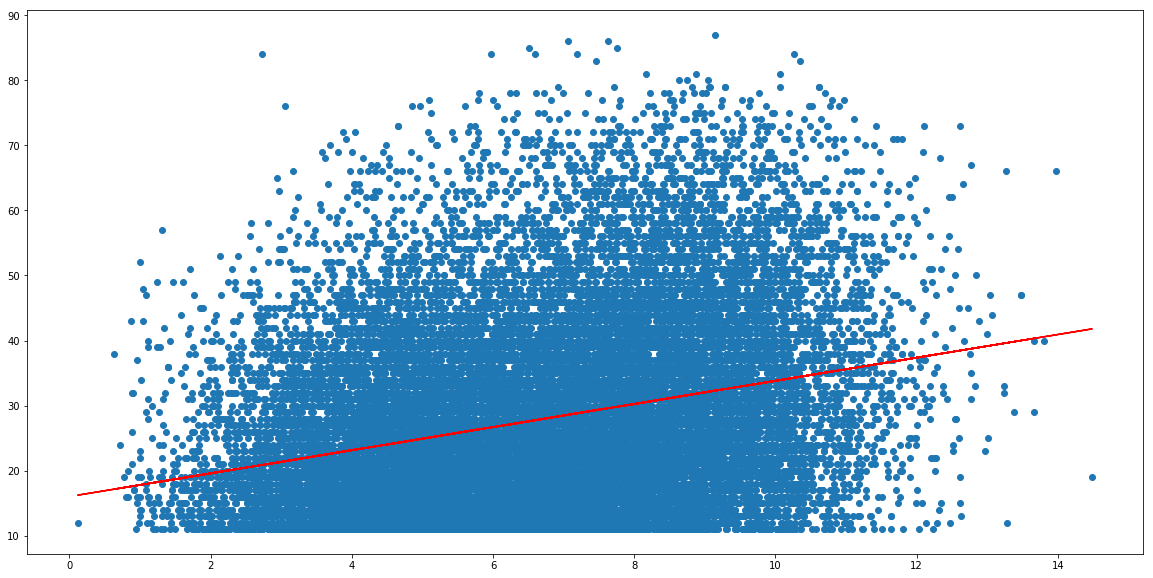

In [253]:
lasso_predict_y = np.exp(lasso_gsc.best_estimator_.predict(X_test))
plt.scatter(lasso_predict_y, np.exp(y_test))
slope, intercept = np.polyfit(lasso_predict_y, np.exp(y_test), 1)
abline_values = [slope * i + intercept for i in lasso_predict_y]
plt.plot(lasso_predict_y, abline_values, 'r')

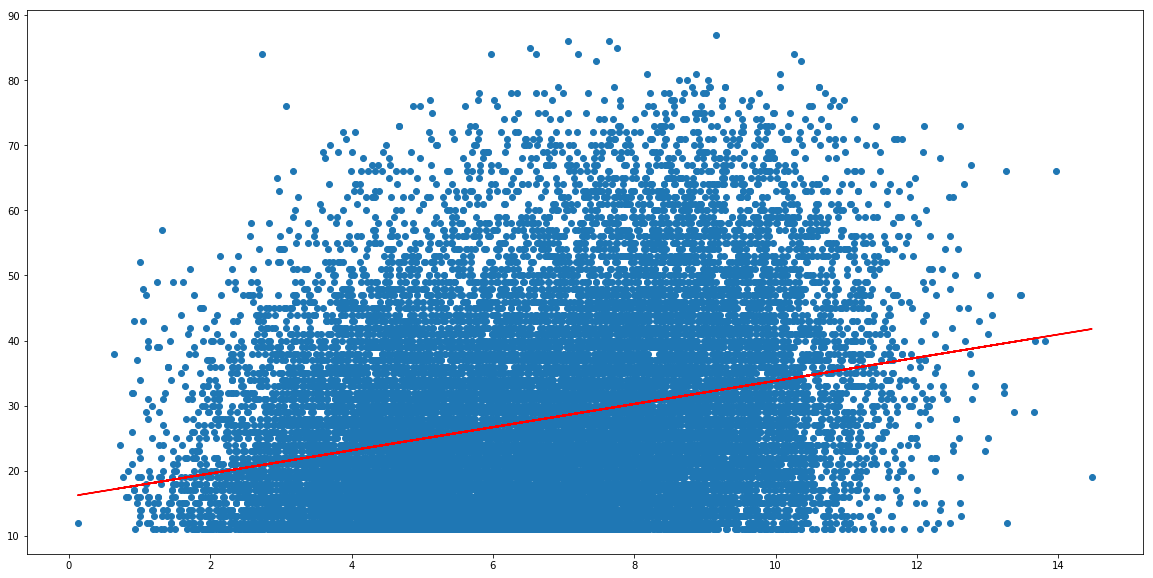

In [252]:
ridge_predict_y = np.exp(ridge_gsc.best_estimator_.predict(X_test))
plt.scatter(ridge_predict_y, np.exp(y_test))
slope, intercept = np.polyfit(ridge_predict_y, np.exp(y_test), 1)
abline_values = [slope * i + intercept for i in ridge_predict_y]
plt.plot(ridge_predict_y, abline_values, 'r')

In [152]:
pd.DataFrame({'lasso coef': lasso_gsc.best_estimator_.coef_, 'ridge coef': ridge_gsc.best_estimator_.coef_}, X_train.columns.values)

,lasso coef,ridge coef
acousticness,-1.021009e-02,-0.010175
danceability,4.023857e-03,0.004038
duration_ms_x,5.824831e-02,0.073210
energy,-4.234043e-03,-0.004192
instrumentalness,-1.991695e-03,-0.002000
liveness,-5.327473e-03,-0.005331
loudness,1.601904e+00,1.598562
speechiness,6.391015e-04,0.000638
tempo,6.491189e-02,0.066204
valence,-1.743278e-02,-0.017427


In [164]:
xgb = xgboost.XGBRegressor(n_estimators=5000, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=0.7, max_depth=7, nthread=3, reg_alpha = 1.2915496650148879e-05)
xgb.fit(X_train, y_train, eval_metric='rmse')

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0, learning_rate=0.08, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=5000, nthread=3,
       objective='reg:linear', reg_alpha=1.291549665014888e-05,
       reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.75)

In [192]:
xgb_predict_y = np.exp(xgb.predict(X_test))
plt.plot(xgb_predict_y, np.exp(y_test))
slope, intercept = np.polyfit(xgb_predict_y, np.exp(y_test), 1)
abline_values = [slope * i + intercept for i in xgb_predict_y]
plt.plot(xgb_predict_y, abline_values, 'r')

KeyboardInterrupt: 

In [243]:
# working on data with popularity > 60 only
audio_popular = audio[audio['popularity'] > 60]
X_ = pd.get_dummies(audio_popular.drop(['popularity', 'name', 'album', 'year', 'month', 'artist', 'explicit', 'decade'], axis=1))
X_.valence.fillna(X_.valence.mean(), inplace=True)
for i in ['acousticness', 'danceability', 'duration_ms_x', 'energy',
       'instrumentalness', 'liveness', 'loudness',
       'speechiness', 'tempo', 'valence']:
    X_[i] = (X_[i] - X_[i].mean())/X_[i].var()
y_ = np.log(audio_popular.popularity)
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, random_state=4222)
X_train_.head()

,acousticness,danceability,duration_ms_x,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,...,key_9,key_10,key_11,mode_0,mode_1,time_signature_0,time_signature_1,time_signature_3,time_signature_4,time_signature_5
259,7.568496,-11.443262,-0.003819,-3.876314,-1.970236,-3.768407,0.354125,-6.545120,-0.051473,-6.926298,...,0,0,0,0,1,0,0,0,1,0
73,9.500087,0.624520,0.007093,-11.942108,-1.968908,-2.888327,-0.739427,-2.385149,-0.053094,-1.660477,...,0,0,0,0,1,0,0,0,1,0
321,10.771305,-10.282898,-0.003279,-0.763675,-1.970236,-4.012874,-0.028608,5.171181,0.004342,-2.812375,...,0,0,0,1,0,0,0,0,1,0
114,-2.384976,-4.527494,-0.004503,5.921731,-1.959713,-1.617100,0.045987,-4.881131,0.021404,-3.232909,...,0,0,0,1,0,0,1,0,0,0
293,5.174643,-10.375727,0.072157,-8.152809,17.112596,-5.298769,-0.590769,-5.827097,0.013608,-8.732767,...,0,0,0,0,1,0,0,0,1,0


In [244]:
lasso_gsc_ = GridSearchCV(lasso_model, params, cv=10)
ridge_gsc_ = GridSearchCV(ridge_model, params, cv=10)
lasso_gsc_.fit(X_train_, y_train_)
ridge_gsc_.fit(X_train_, y_train_)
print(lasso_gsc_.best_params_)
print(ridge_gsc_.best_params_)

{'alpha': 0.00035938136638046257}
{'alpha': 166.81005372000593}


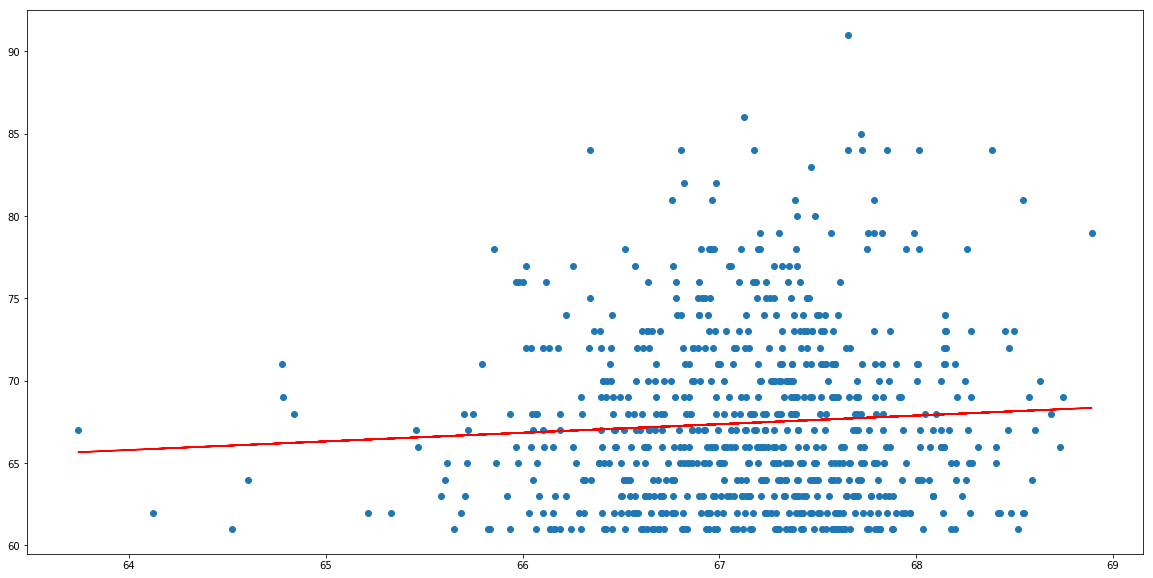

In [251]:
lasso_predict_y_ = np.exp(lasso_gsc_.best_estimator_.predict(X_test_))
plt.scatter(lasso_predict_y_, np.exp(y_test_))
slope, intercept = np.polyfit(lasso_predict_y_, np.exp(y_test_), 1)
abline_values = [slope * i + intercept for i in lasso_predict_y_]
plt.plot(lasso_predict_y_, abline_values, 'r')

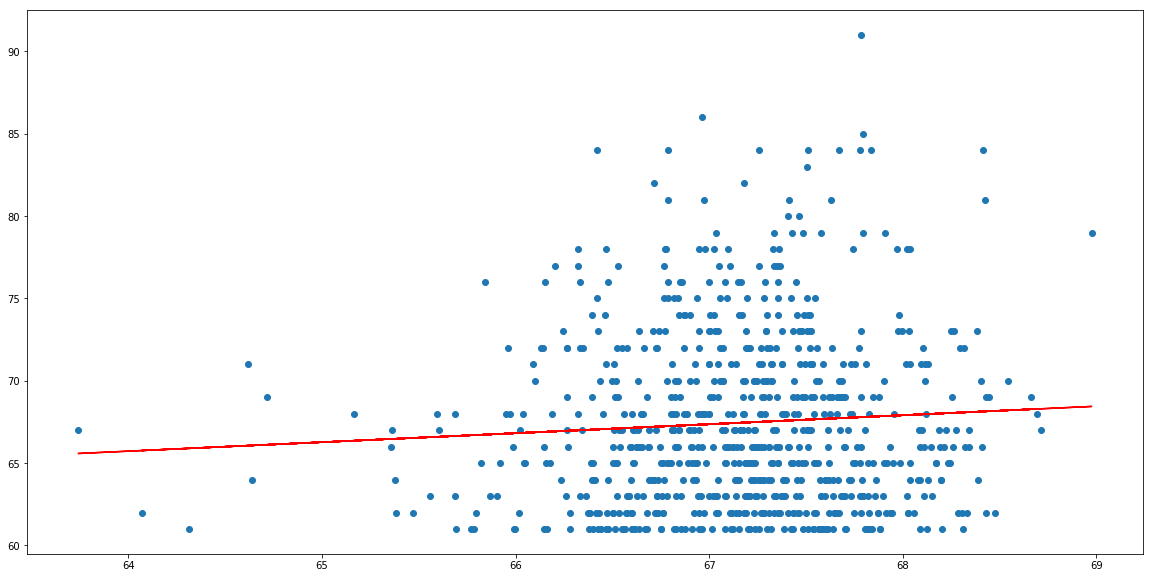

In [250]:
ridge_predict_y_ = np.exp(ridge_gsc_.best_estimator_.predict(X_test_))
plt.scatter(ridge_predict_y_, np.exp(y_test_))
slope, intercept = np.polyfit(ridge_predict_y_, np.exp(y_test_), 1)
abline_values = [slope * i + intercept for i in ridge_predict_y_]
plt.plot(ridge_predict_y_, abline_values, 'r')

In [247]:
xgb_ = xgboost.XGBRegressor(n_estimators=5000, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=0.7, max_depth=7, nthread=3, reg_alpha = 0.00035938136638046257)
xgb_.fit(X_train_, y_train_, eval_metric='rmse')

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0, learning_rate=0.08, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=5000, nthread=3,
       objective='reg:linear', reg_alpha=0.00035938136638046257,
       reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.75)

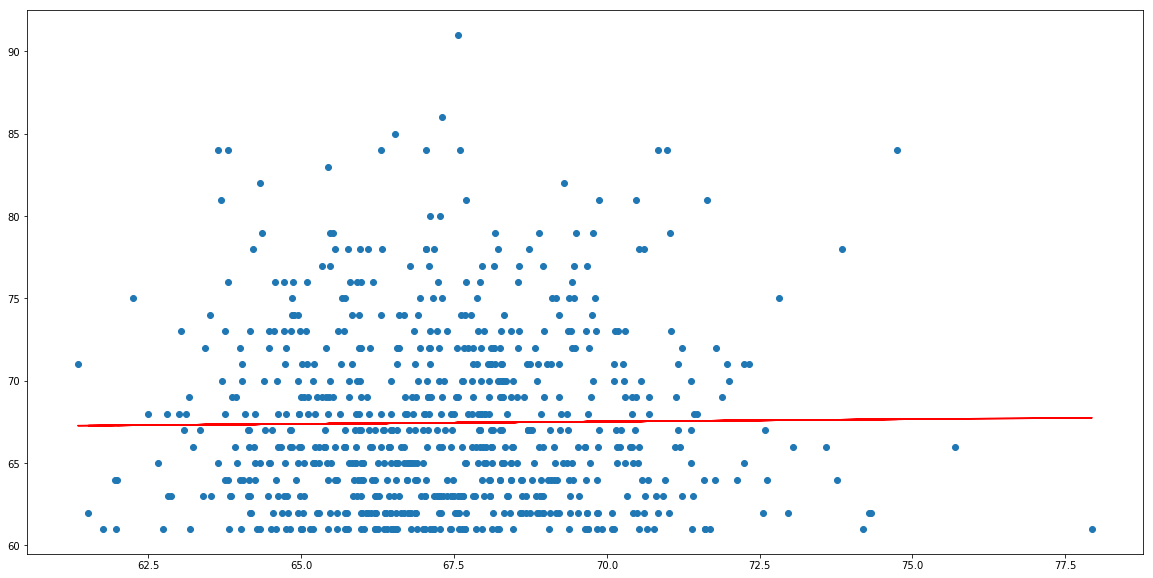

In [249]:
xgb_predict_y_ = np.exp(xgb_.predict(X_test_))
plt.scatter(xgb_predict_y_, np.exp(y_test_))
slope, intercept = np.polyfit(xgb_predict_y_, np.exp(y_test_), 1)
abline_values = [slope * i + intercept for i in xgb_predict_y_]
plt.plot(xgb_predict_y_, abline_values, 'r')

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence
0,0.7130,0.582,140.866,0.575,0.000004,7,0.1510,-11.890,1,52,0.0529,140.601,0.558
1,0.2040,0.686,163.680,0.714,0.000000,0,0.0592,-4.809,1,64,0.0287,126.736,0.964
2,0.0348,0.725,222.813,0.853,0.127000,2,0.1960,-7.842,1,68,0.0353,136.282,0.904
4,0.5040,0.390,225.226,0.309,0.000000,1,0.0863,-14.120,1,56,0.0265,94.444,0.459
5,0.6950,0.495,183.120,0.629,0.000000,4,0.1640,-6.817,1,51,0.0431,118.515,0.545


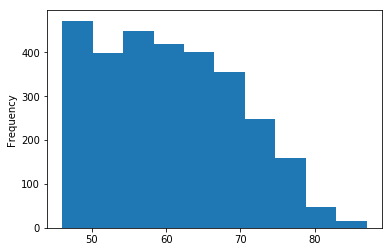

In [5]:
billboard = pd.read_csv("billboard_top_100.csv", encoding='latin1')
billboard.drop(['type', 'uri', 'lyrics','artist','track','explicit'], axis = 1, inplace = True)
billboard[['key', 'mode', 'mode']] = billboard[['key', 'mode', 'mode']].astype(np.object)
billboard.duration_ms = billboard.duration_ms/1000
billboard = billboard[billboard.popularity>45]
billboard.popularity.plot.hist()
billboard.head()

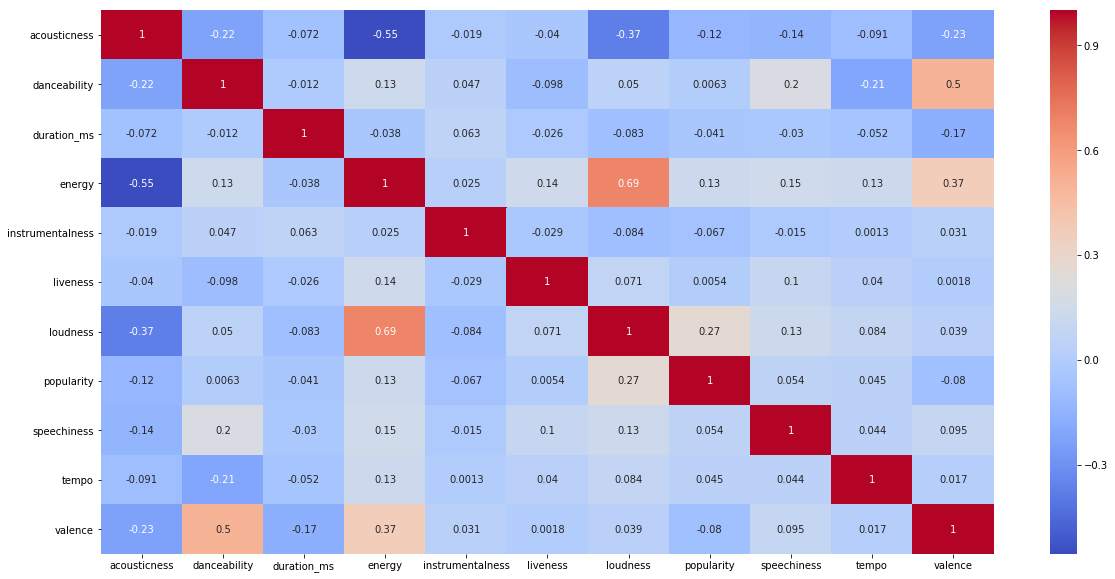

In [231]:
plt.rcParams['figure.figsize'] = [20, 10]
sns.heatmap(billboard.corr(), cmap='coolwarm', annot=True)

In [4]:
billboard = pd.get_dummies(billboard)
billboard_X = billboard.drop(['popularity'], axis=1)
billboard_y = np.log(billboard['popularity'])
for i in ['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness',
       'speechiness', 'tempo', 'valence']:
    billboard_X[i] = (billboard_X[i] - billboard_X[i].mean())/billboard_X[i].var()

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(billboard_X, billboard_y, random_state=4222)

NameError: name 'billboard' is not defined

In [233]:
lasso_bill = Lasso()
lasso_bill_gsc = GridSearchCV(lasso_bill, params)
lasso_bill_gsc.fit(X_train_b, y_train_b)

GridSearchCV(cv=None, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([  1.00000e+05,   7.74264e+04, ...,   1.29155e-06,   1.00000e-06])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

{'alpha': 0.00077426368268112774}


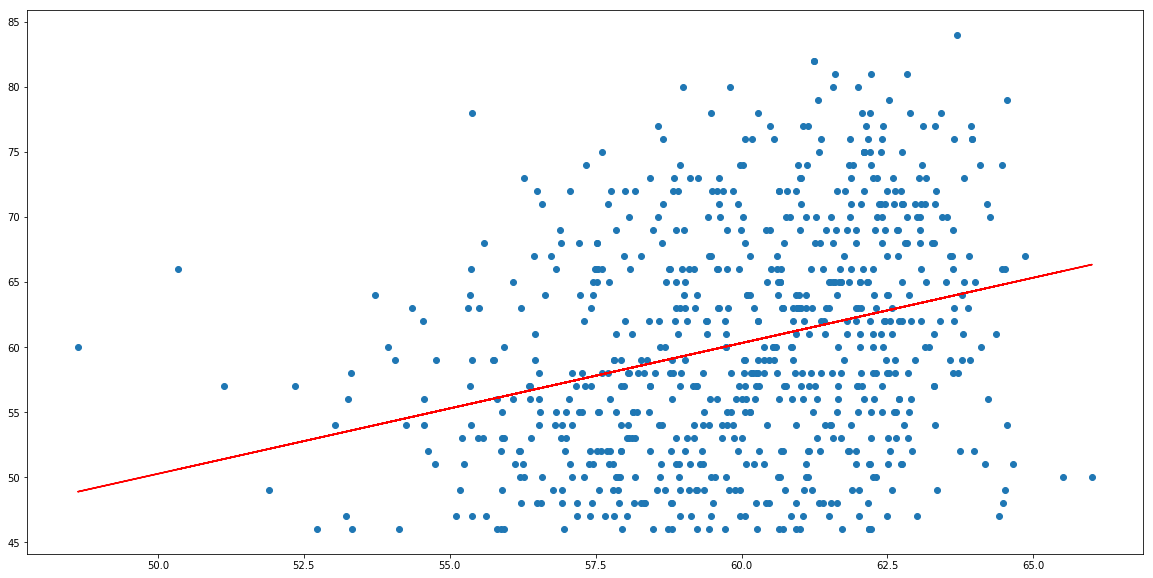

In [255]:
print(lasso_bill_gsc.best_params_)
lasso_predict_y_b = np.exp(lasso_bill_gsc.best_estimator_.predict(X_test_b))
plt.scatter(lasso_predict_y_b, np.exp(y_test_b))
slope, intercept = np.polyfit(lasso_predict_y_b, np.exp(y_test_b), 1)
abline_values = [slope * i + intercept for i in lasso_predict_y_b]
plt.plot(lasso_predict_y_b, abline_values, 'r')

In [32]:
params = {
    'alpha': 10**np.linspace(5,-6,100)
}

billboard = pd.read_csv("billboard_rank.csv", encoding='latin1')
billboard = billboard.dropna()
billboard.drop(['type', 'uri', 'lyrics_y','lyrics_x','popularity_x','popularity_y','artist','track','explicit'], axis = 1, inplace = True)
billboard[['key', 'mode', 'mode']] = billboard[['key', 'mode', 'mode']].astype(np.object)
billboard.duration_ms = billboard.duration_ms/1000
billboard = pd.get_dummies(billboard)
billboard_X = billboard.drop(['Rank'], axis=1)
billboard_y = np.log(billboard['Rank'])
for i in ['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness',
       'speechiness', 'tempo', 'valence']:
    billboard_X[i] = (billboard_X[i] - billboard_X[i].mean())/billboard_X[i].var()

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(billboard_X, billboard_y, random_state=4222)


In [33]:
billboard_y

0       0.000000
1       0.693147
2       1.098612
3       1.386294
4       1.609438
5       1.791759
6       1.945910
7       2.079442
8       2.197225
9       2.302585
10      2.397895
11      2.484907
12      2.564949
13      2.639057
14      2.772589
15      2.833213
16      2.890372
17      2.944439
18      2.995732
19      3.044522
20      3.091042
21      3.135494
22      3.178054
23      3.218876
24      3.258097
26      3.332205
27      3.367296
28      3.401197
29      3.433987
30      3.465736
          ...   
4630    2.484907
4631    2.564949
4632    2.639057
4633    2.833213
4634    2.995732
4635    3.218876
4636    3.258097
4637    3.367296
4639    3.583519
4640    3.610918
4641    3.806662
4642    3.871201
4643    3.891820
4644    3.951244
4645    3.970292
4646    3.988984
4647    4.043051
4648    4.094345
4649    4.127134
4651    4.248495
4652    4.262680
4653    4.304065
4654    4.369448
4655    4.394449
4656    4.442651
4657    4.488636
4658    4.510860
4659    4.5325

{'alpha': 0.0046415888336127824}


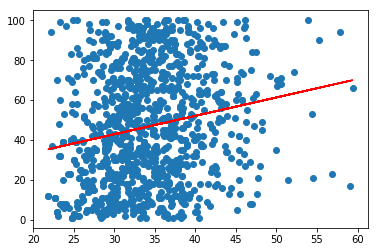

In [34]:
lasso_bill = Lasso()
lasso_bill_gsc = GridSearchCV(lasso_bill, params)
lasso_bill_gsc.fit(X_train_b, y_train_b)
print(lasso_bill_gsc.best_params_)
lasso_predict_y_b = np.exp(lasso_bill_gsc.best_estimator_.predict(X_test_b))
plt.scatter(lasso_predict_y_b, np.exp(y_test_b))
slope, intercept = np.polyfit(lasso_predict_y_b, np.exp(y_test_b), 1)
abline_values = [slope * i + intercept for i in lasso_predict_y_b]
plt.plot(lasso_predict_y_b, abline_values, 'r')